# Sentiment Analysis on the Wall Street Bets Subreddit

## Importing Libraries

In [ ]:
import pandas as pd
import pyodbc
import time
import numpy as np
from datetime import date, timedelta, datetime
from dateutil import parser
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import sys
import matplotlib.pyplot as plt

!conda install pandoc

## Setup Database Connection

In [3]:
db = pyodbc.connect('Driver={SQL Server};', server='localhost', database='RedditData', trusted_connection='yes')
cursor = db.cursor()


def sqlquery(q):
    cursor.execute(q)
    rows = cursor.fetchall()
    return rows

## Raw Data

In [15]:
postData = pd.read_sql("select TOP 10 * from Posts ORDER BY CreatedAtUtc desc", db)
postData

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\1516618716.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  postData = pd.read_sql("select TOP 10 * from Posts ORDER BY CreatedAtUtc desc", db)


Author AuthorFullName AuthorPremium ContestMode   
0         Moneyjunkie4L    t2_9tmwmtr1         False       False  \
1      Frosty_Huskers07    t2_56v6rf73         False       False   
2               smgnyc4       t2_xhavf         False       False   
3         FlatWhite2020    t2_8jszbiec         False       False   
4  MohammadBashirSidani    t2_2fxofizj         False       False   
5  ClassroomJealous1631    t2_a1lpphp0         False       False   
6             m4xsch44f    t2_38u3nggu         False       False   
7               CrsCrpr    t2_3sd0gpaq         False       False   
8             kanwarusa    t2_a0vbz19e         False       False   
9            Erdrick_XI    t2_21a3hjyf         False       False   

                  CreatedAtUtc               Domain   
0  2021-03-04 21:41:41.0000000  self.wallstreetbets  \
1  2021-03-04 21:41:38.0000000           reddit.com   
2  2021-03-04 21:41:19.0000000            i.redd.it   
3  2021-03-04 21:40:49.0000000  self.wallstreetbets   
4  2021-03-04 21:40:44.0000000            i.redd.it   
5  2021-03-04 21:40:44.0000000  self.wallstreetbets   
6  2021-03-04 21:40:26.0000000            i.redd.it   
7  2021-03-04 21:40:11.0000000  self.wallstreetbets   
8  2021-03-04 21:40:10.0000000  self.wallstreetbets   
9  2021-03-04 21:40:03.0000000  self.wallstreetbets   

                                             FullUri  PostId IsMeta   
0  https://www.reddit.com/r/wallstreetbets/commen...  lxw72r  False  \
1  https://www.reddit.com/r/wallstreetbets/commen...  lxw71s  False   
2  https://www.reddit.com/r/wallstreetbets/commen...  lxw6t8  False   
3  https://www.reddit.com/r/wallstreetbets/commen...  lxw6fa  False   
4  https://www.reddit.com/r/wallstreetbets/commen...  lxw6d5  False   
5  https://www.reddit.com/r/wallstreetbets/commen...  lxw6d1  False   
6  https://www.reddit.com/r/wallstreetbets/commen...  lxw652  False   
7  https://www.reddit.com/r/wallstreetbets/commen...  lxw5xk  False   
8  https://www.reddit.com/r/wallstreetbets/commen...  lxw5xd  False   
9  https://www.reddit.com/r/wallstreetbets/commen...  lxw5ts  False   

  IsOriginalContent  ... TotalDownVotes   
0             False  ...            0.0  \
1             False  ...            0.0   
2             False  ...            0.0   
3             False  ...            0.0   
4             False  ...            0.0   
5             False  ...            0.0   
6             False  ...            0.0   
7             False  ...            0.0   
8             False  ...            0.0   
9             False  ...            0.0   

                                                 Url WhiteListStatus   
0  https://www.reddit.com/r/wallstreetbets/commen...        some_ads  \
1              https://www.reddit.com/gallery/lxw71s        some_ads   
2                https://i.redd.it/8kpg0d0pz2l61.jpg        some_ads   
3  https://www.reddit.com/r/wallstreetbets/commen...        some_ads   
4                https://i.redd.it/n0dqo1giz2l61.jpg        some_ads   
5  https://www.reddit.com/r/wallstreetbets/commen...        some_ads   
6                https://i.redd.it/ozvv11zgz2l61.jpg        some_ads   
7  https://www.reddit.com/r/wallstreetbets/commen...        some_ads   
8  https://www.reddit.com/r/wallstreetbets/commen...        some_ads   
9  https://www.reddit.com/r/wallstreetbets/commen...        some_ads   

  WhiteLists SubredditSubscribers TotalVotes   
0          7              9424316        1.0  \
1          7              9424316        1.0   
2          7              9424314        1.0   
3          7              9424307        1.0   
4          7              9424306        1.0   
5          7              9424306        1.0   
6          7              9424305        1.0   
7          7              9424301        1.0   
8          7              9424301        1.0   
9          7              9424300        2.0   

                                         TokenCounts   
0                           

In [16]:
commentData = pd.read_sql("select TOP 10 * from Comments ORDER BY created_utc desc", db)
commentData

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\1227761783.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  commentData = pd.read_sql("select TOP 10 * from Comments ORDER BY created_utc desc", db)


archived                author comment_banned banned_at_utc   
0    False              Dredog83          False          None  \
1    False              Sandroli          False          None   
2    False  Comfortable_Banana80          False          None   
3    False               JamySun          False          None   
4    False                 WR810          False          None   
5    False        STONK_MASTER21          False          None   
6    False           PencilChant          False          None   
7    False         throawaway604          False          None   
8    False          ETHBAGHOLDER          False          None   
9    False          WillTheGreat          False          None   

                                                body comment_type   
0  My moves tomorrow are being hungover as fuck i...         None  \
1                                   Guy was the goat         None   
2  your lines are incorrect. theyre supposed to c...         None   
3  Lol, Current picture of PLTR 30 call expiring ...         None   
4                       No, red Mondays are illegal.         None   
5                          January effect is mooning         None   
6  Whoever is selling you these edibles is straig...         None   
7  if you invested in coke, it would have doubled...         None   
8                                              True.         None   
9  Electoral college exist because those who were...         None   

   controversiality          created_utc  depth distinguished  ...  score   
0                 0  12/31/2020 23:59:58      0         False  ...      0  \
1                 0  12/31/2020 23:59:56      1         False  ...      4   
2                 0  12/31/2020 23:59:54      0         False  ...      3   
3                 0  12/31/2020 23:59:51      0         False  ...      1   
4                 0  12/31/2020 23:59:51      1         False  ...      1   
5                 0  12/31/2020 23:59:48      1         False  ...      1   
6                 0  12/31/2020 23:59:47      3         False  ...      7   
7                 0  12/31/2020 23:59:39      3         False  ...      5   
8                 0  12/31/2020 23:59:38      1         False  ...      1   
9                 0  12/31/2020 23:59:36      4         False  ...    -10   

  score_hidden stickied       subreddit subreddit__id  total_awards_received   
0        False    False  wallstreetbets      t5_2th52                      0  \
1        False    False  wallstreetbets      t5_2th52                      0   
2        False    False  wallstreetbets      t5_2th52                      0   
3        False    False  wallstreetbets      t5_2th52                      0   
4        False    False  wallstreetbets      t5_2th52                      0   
5        False    False  wallstreetbets      t5_2th52                      0   
6        False    False  wallstreetbets      t5_2th52                      0   
7        False    False  wallstreetbets      t5_2th52                      0   
8        False    False  wallstreetbets      t5_2th52                      0   
9        False    False  wallstreetbets      t5_2th52                      0   

  upvotes                                token_counts_unique   
0       0  {"moves":1,"tomorrow":1,"are":1,"hungover":1,"...  \
1       4                                 {"guy":1,"goat":1}   
2       3  {"lines":1,"are":1,"incorrect":1,"theyre":1,"s...   
3       1  {"lol":1,"current":1,"picture":1,"PLTR":1,"30"...   
4       1          {"red":1,"mondays":1,"are":1,"illegal":1}   
5       1               {"january":1,"effect":1,"mooning":1}   
6       7  {"selling":1,"edibles":2,"straight":1,"lying":...   
7       5  {"invested":1,"coke":1,"it":1,"doubled":1,"pan...   
8       1                                         {"true":1}   
9     -10  {"electoral":1,"college":1,"exist":1,"governin...   

                                     bigrams_ordered   
0  ["My moves","moves tomorrow","tom

## Run Sentiment Analysis

In [11]:
def preprocess_text(text):
    # Tokenize the text]
    if text is None:
        return None
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text


def get_sentiment(text):
    if text is None:
        return 0
    scores = analyzer.polarity_scores(text)
    return scores['compound']

In [ ]:
analyzer = SentimentIntensityAnalyzer()

startDate = parser.parse("2012-04-11")
endDate = parser.parse(sqlquery("SELECT Max(CreatedAtUtc) FROM RedditData.dbo.Posts")[0][0])

delta = endDate - startDate

for i in range(delta.days + 1):
    firstDay = startDate + timedelta(days=i)
    secondDay = startDate + timedelta(days=i + 1)
    postQuery = f"SELECT PostId, PostTitle, selftext, CreatedAtUtc from Posts where CreatedAtUtc >= '{firstDay.strftime('%Y-%m-%d')}' AND CreatedAtUtc < '{secondDay.strftime('%Y-%m-%d')}'"
    posts = pd.read_sql(postQuery, db)

    if posts.empty:
        continue

    posts['titleSentiment'] = posts['PostTitle'].apply(get_sentiment)

    if posts['selftext'] is not None:
        posts['cleanText'] = posts['selftext'].apply(preprocess_text)
        posts['bodySentiment'] = posts['cleanText'].apply(get_sentiment)

    postString = ''
    for p in posts['PostId']:
        postString += '\'t3_' +p + '\','

    commentQuery = f"SELECT body, created_utc, post_id FROM RedditData.dbo.Comments WHERE post_id in ({postString.rstrip(postString[-1])})"

    allComments = pd.read_sql(commentQuery, db)

    values = ""
    for index, post in posts.iterrows():

        comments = allComments[allComments['post_id'] == 't3_' + post['PostId']]
        if comments.empty:
            values += f"('{firstDay.strftime('%Y-%m-%d')}', {post['bodySentiment']}, {post['titleSentiment']}, {0}, 't3_{post['PostId']}'),"
            continue

        if comments['body'] is not None:
            comments['cleanText'] = comments['body'].apply(preprocess_text)
            comments['sentiment'] = comments['cleanText'].apply(get_sentiment)
        values += f"('{firstDay.strftime('%Y-%m-%d')}', {post['bodySentiment']}, {post['titleSentiment']}, {comments['sentiment'].mean()}, 't3_{post['PostId']}'),"

    query = f"INSERT INTO RedditData.dbo.SentimentAnalysis (Date, BodySentimentScore, TitleSentimentScore, CommentSentimentScore, PostId) VALUES {values.rstrip(postString[-1])}"
    cursor.execute(query)
    db.commit()


## Create Temp Tables with Sentiment Averages

In [ ]:
createTempTables = f"DROP TABLE IF EXISTS ##TitleSentiment DROP TABLE IF EXISTS ##BodySentiment DROP TABLE IF EXISTS ##CommentSentiment SELECT AVG(TitleSentimentScore) AS TitleSentimentaverage, Date AS Date INTO ##TitleSentiment FROM SentimentAnalysis WHERE TitleSentimentScore != 0 GROUP BY Date SELECT AVG(BodySentimentScore) AS BodySentimentaverage, Date AS Date INTO ##BodySentiment FROM SentimentAnalysis WHERE BodySentimentScore != 0 GROUP BY Date SELECT AVG(CommentSentimentScore) AS CommentSentimentaverage, Date AS Date INTO ##CommentSentiment FROM SentimentAnalysis WHERE CommentSentimentScore != 0 GROUP BY Date"

cursor.execute(createTempTables)
db.commit()

## Retrieve Sentiment Data

In [55]:
bodyQuery = "SELECT " \
            "BodySentimentAverage as BodyDailySentimentAverage, " \
            "avg(BodySentimentAverage) OVER(order by Date ROWS BETWEEN 4 PRECEDING AND CURRENT ROW ) as BodySentimentFiveDayAverage, " \
            "avg(BodySentimentAverage) OVER(order by Date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW ) as BodySentiment30DayAverage, " \
            "Date " \
            "FROM ##BodySentiment ORDER BY date asc"
bodySentiment = pd.read_sql(bodyQuery, db)


titleQuery = "SELECT " \
            "TitleSentimentAverage as TitleDailySentimentAverage, " \
            "avg(TitleSentimentAverage) OVER(order by Date ROWS BETWEEN 4 PRECEDING AND CURRENT ROW ) as TitleSentimentFiveDayAverage, " \
            "avg(TitleSentimentAverage) OVER(order by Date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW ) as TitleSentiment30DayAverage, " \
            "Date " \
            "FROM ##TitleSentiment ORDER BY date asc"
titleSentiment = pd.read_sql(titleQuery, db)

commentQuery = "SELECT " \
            "CommentSentimentAverage as CommentDailySentimentAverage, " \
            "avg(CommentSentimentAverage) OVER(order by Date ROWS BETWEEN 4 PRECEDING AND CURRENT ROW ) as CommentSentimentFiveDayAverage, " \
            "avg(CommentSentimentAverage) OVER(order by Date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW ) as CommentSentiment30DayAverage, " \
            "Date " \
            "FROM ##CommentSentiment ORDER BY date asc"
commentSentiment = pd.read_sql(commentQuery, db)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\3221980996.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bodySentiment = pd.read_sql(bodyQuery, db)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\3221980996.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  titleSentiment = pd.read_sql(titleQuery, db)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\3221980996.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  commentSentiment = pd.read_sql(commentQuery, db)


In [56]:
titleSentiment['date'] = pd.to_datetime(titleSentiment['Date'])
titleSentiment.head(10)

TitleDailySentimentAverage  TitleSentimentFiveDayAverage   
0                    0.476700                      0.476700  \
1                    0.025800                      0.251250   
2                    0.202300                      0.234933   
3                    0.010850                      0.178913   
4                    0.690800                      0.281290   
5                    0.492600                      0.284470   
6                    0.542300                      0.387770   
7                    0.434167                      0.434143   
8                    0.321350                      0.496243   
9                    0.361200                      0.430323   

   TitleSentiment30DayAverage                         Date       date  
0                    0.476700  2012-04-17 00:00:00.0000000 2012-04-17  
1                    0.251250  2012-04-19 00:00:00.0000000 2012-04-19  
2                    0.234933  2012-04-24 00:00:00.0000000 2012-04-24  
3                    0.178913  2012-04-25 00:00:00.0000000 2012-04-25  
4                    0.281290  2012-04-26 00:00:00.0000000 2012-04-26  
5                    0.316508  2012-04-27 00:00:00.0000000 2012-04-27  
6                    0.348764  2012-05-01 00:00:00.0000000 2012-05-01  
7                    0.359440  2012-05-02 00:00:00.0000000 2012-05-02  
8                    0.355207  2012-05-04 00:00:00.0000000 2012-05-04  
9                    0.355807  2012-05-05 00:00:00.0000000 2012-05-05

In [57]:
bodySentiment['date'] = pd.to_datetime(bodySentiment['Date'])
bodySentiment.head(10)

BodyDailySentimentAverage  BodySentimentFiveDayAverage   
0                   0.842300                     0.842300  \
1                   0.355300                     0.598800   
2                   0.969400                     0.722333   
3                  -0.340000                     0.456750   
4                   0.349750                     0.435350   
5                   0.629575                     0.392805   
6                   0.694967                     0.460738   
7                   0.357500                     0.338358   
8                   0.834367                     0.573232   
9                   0.556380                     0.614558   

   BodySentiment30DayAverage                         Date       date  
0                   0.842300  2012-04-11 00:00:00.0000000 2012-04-11  
1                   0.598800  2012-04-16 00:00:00.0000000 2012-04-16  
2                   0.722333  2012-04-17 00:00:00.0000000 2012-04-17  
3                   0.456750  2012-04-21 00:00:00.0000000 2012-04-21  
4                   0.435350  2012-04-25 00:00:00.0000000 2012-04-25  
5                   0.467721  2012-04-26 00:00:00.0000000 2012-04-26  
6                   0.500185  2012-04-27 00:00:00.0000000 2012-04-27  
7                   0.482349  2012-04-30 00:00:00.0000000 2012-04-30  
8                   0.521462  2012-05-01 00:00:00.0000000 2012-05-01  
9                   0.524954  2012-05-02 00:00:00.0000000 2012-05-02

In [58]:
commentSentiment['date'] = pd.to_datetime(commentSentiment['Date'])
commentSentiment.head(10)

CommentDailySentimentAverage  CommentSentimentFiveDayAverage   
0                      0.201070                        0.201070  \
1                      0.370560                        0.285815   
2                      0.256200                        0.275943   
3                      0.372540                        0.300092   
4                      0.124058                        0.264886   
5                      0.222280                        0.269128   
6                      0.148154                        0.224646   
7                      0.173281                        0.208063   
8                      0.401160                        0.213787   
9                      0.403108                        0.269597   

   CommentSentiment30DayAverage                         Date       date  
0                      0.201070  2012-04-11 00:00:00.0000000 2012-04-11  
1                      0.285815  2012-04-16 00:00:00.0000000 2012-04-16  
2                      0.275943  2012-04-19 00:00:00.0000000 2012-04-19  
3                      0.300092  2012-04-21 00:00:00.0000000 2012-04-21  
4                      0.264886  2012-04-23 00:00:00.0000000 2012-04-23  
5                      0.257785  2012-04-24 00:00:00.0000000 2012-04-24  
6                      0.242123  2012-04-25 00:00:00.0000000 2012-04-25  
7                      0.233518  2012-04-26 00:00:00.0000000 2012-04-26  
8                      0.252145  2012-04-27 00:00:00.0000000 2012-04-27  
9                      0.267241  2012-04-30 00:00:00.0000000 2012-04-30

## Differences in Sentiment

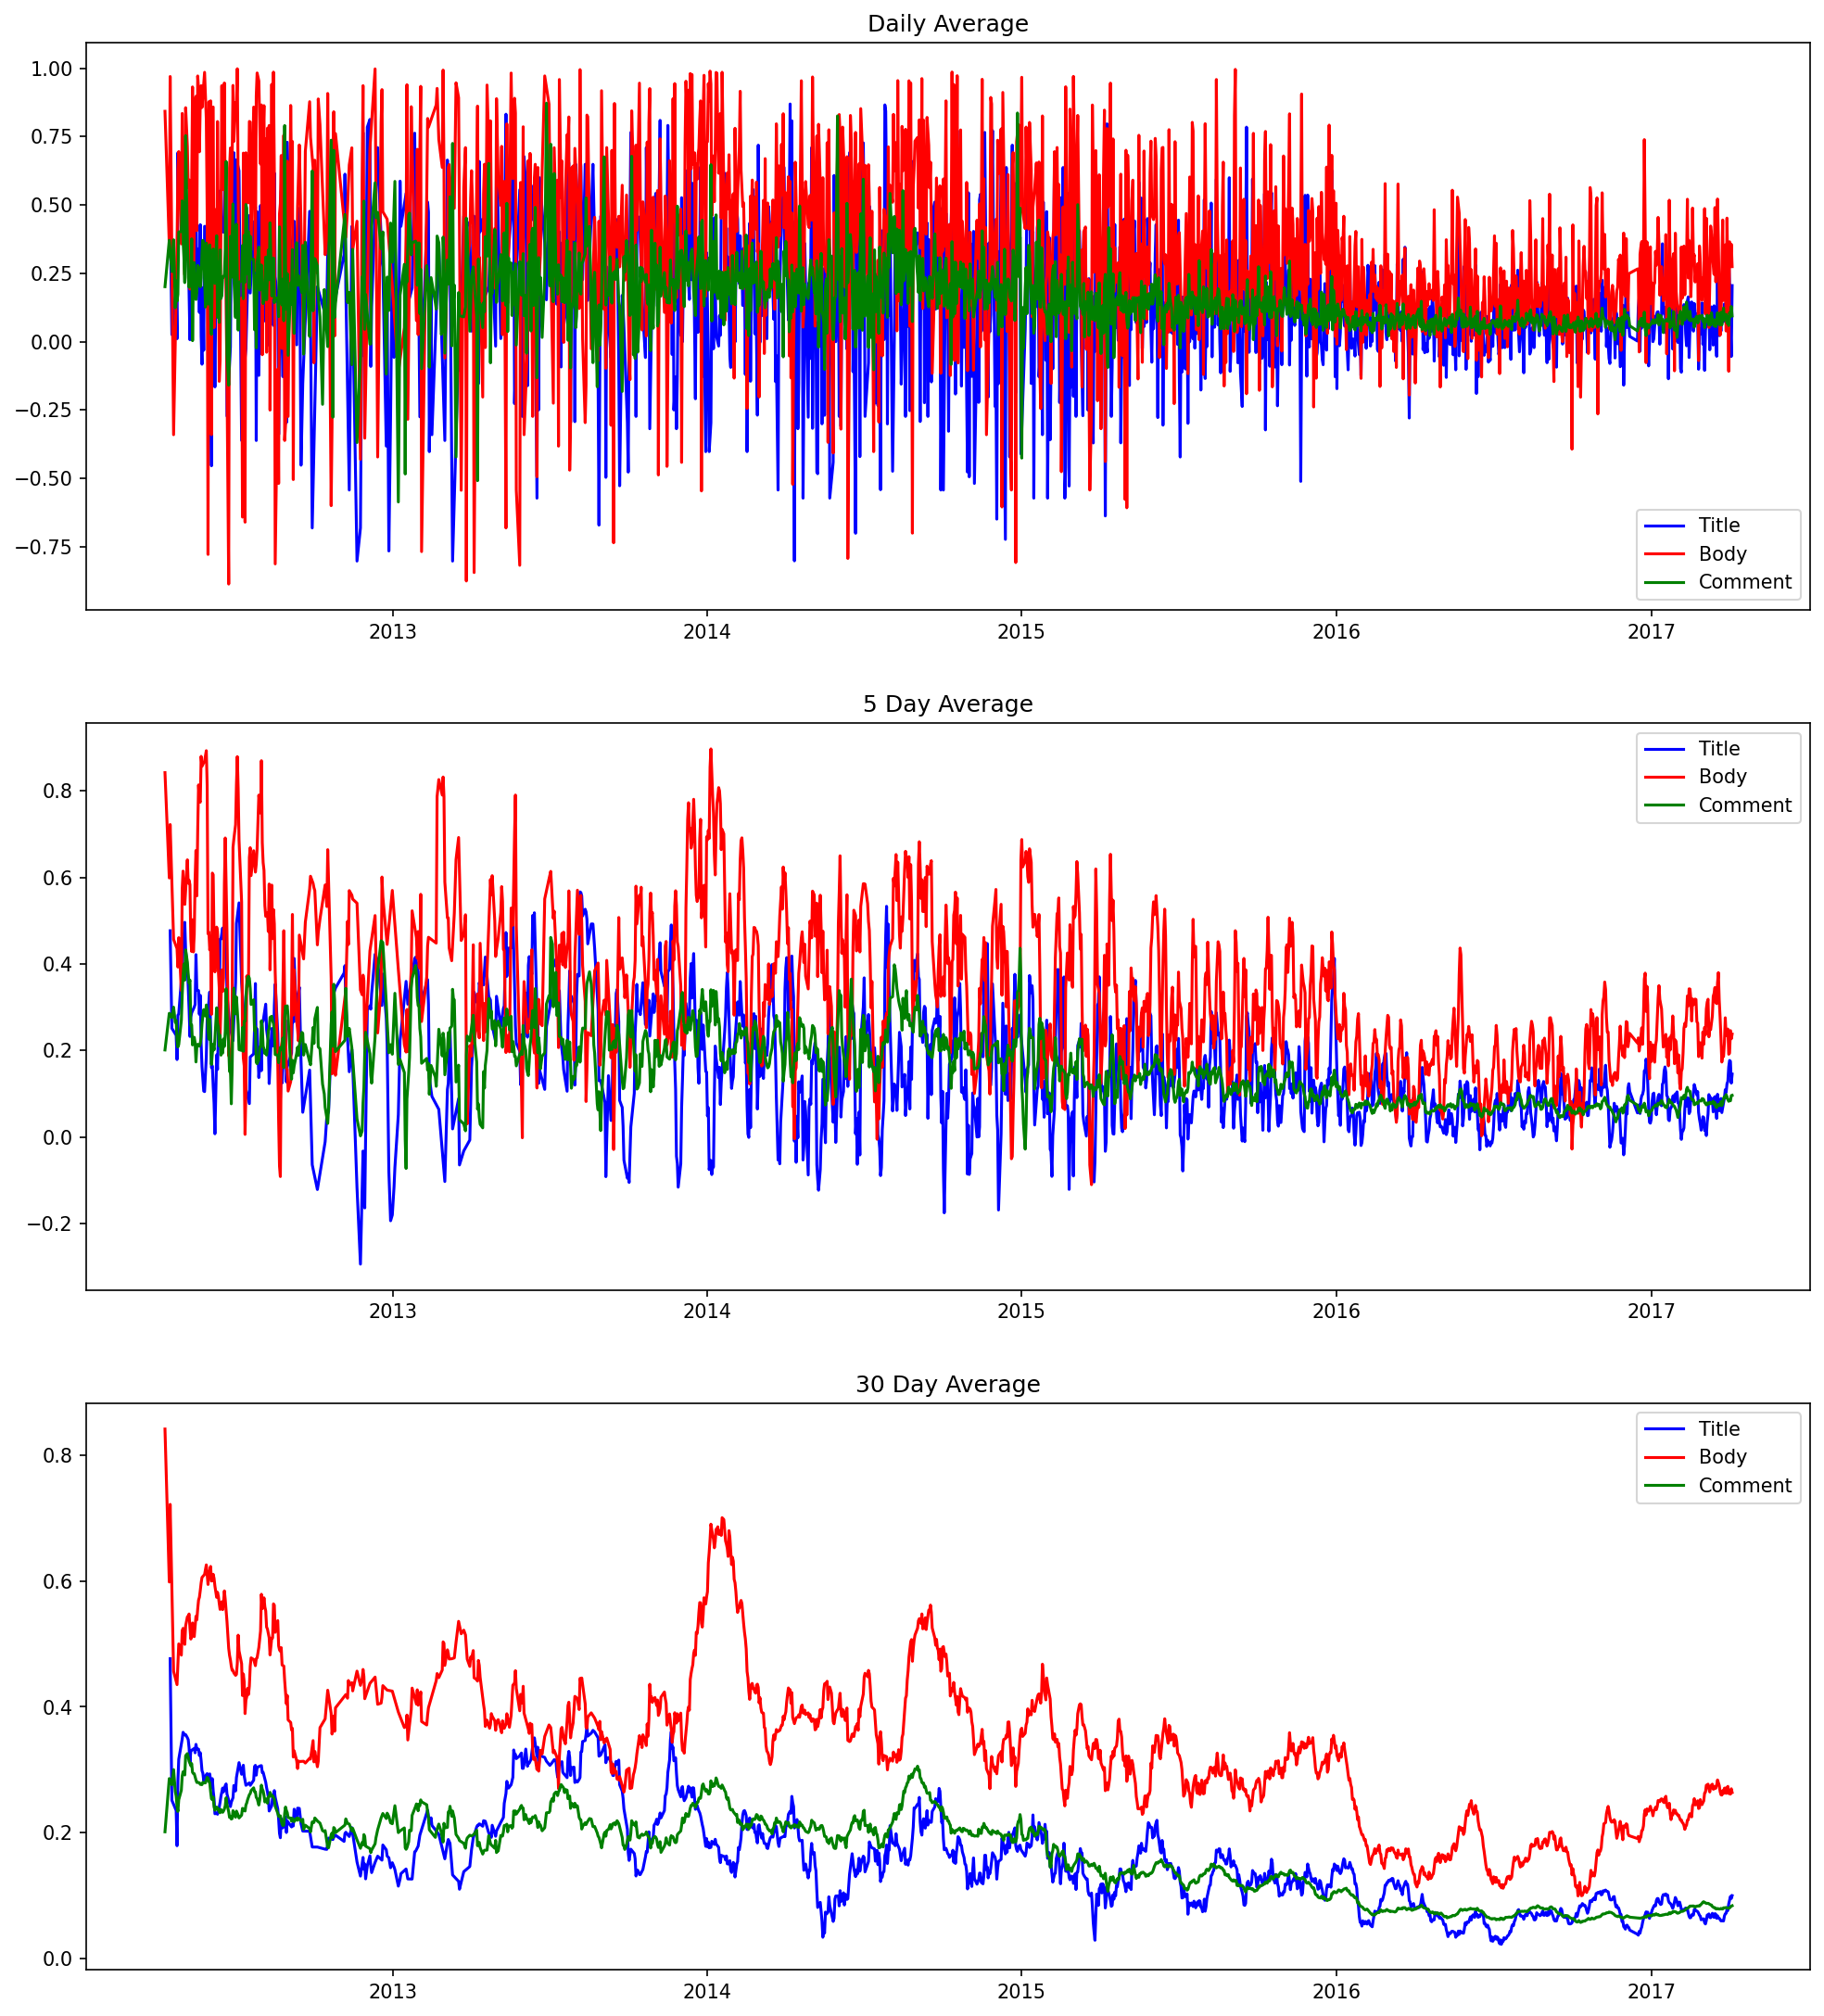

In [90]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Sentiment Differences')

axes[0].set_title('Daily Average')
axes[0].plot(titleSentiment['date'], titleSentiment['TitleDailySentimentAverage'], label='Title', color='blue')
axes[0].plot(bodySentiment['date'], bodySentiment['BodyDailySentimentAverage'], label='Body', color='red')
axes[0].plot(commentSentiment['date'], commentSentiment['CommentDailySentimentAverage'], label='Comment', color='green')
axes[0].legend()

axes[1].set_title('5 Day Average')
axes[1].plot(titleSentiment['date'], titleSentiment['TitleSentimentFiveDayAverage'], label='Title', color='blue')
axes[1].plot(bodySentiment['date'], bodySentiment['BodySentimentFiveDayAverage'], label='Body', color='red')
axes[1].plot(commentSentiment['date'], commentSentiment['CommentSentimentFiveDayAverage'], label='Comment',
             color='green')
axes[1].legend()

axes[2].set_title('30 Day Average')
axes[2].plot(titleSentiment['date'], titleSentiment['TitleSentiment30DayAverage'], label='Title', color='blue')
axes[2].plot(bodySentiment['date'], bodySentiment['BodySentiment30DayAverage'], label='Body', color='red')
axes[2].plot(commentSentiment['date'], commentSentiment['CommentSentiment30DayAverage'], label='Comment', color='green')
axes[2].legend()

## Load and Normalize Exchange Data

In [96]:
djia = pd.read_csv("data/DJIA Historical.csv")

djia['Close'] = djia['Close'].str.replace(',', '').astype(float)
djia['Volume'] = djia['Volume'].str.replace(',', '').astype(float)
djia['NormalizedClose'] = 2 * (djia['Close'] - np.min(djia['Close']))/(np.max(djia['Close']) - np.min(djia['Close'])) - 1
djia['NormalizedVolume'] = 2 * (djia['Volume'] - np.min(djia['Volume']))/(np.max(djia['Volume']) - np.min(djia['Volume'])) - 1
djia['date'] = pd.to_datetime(djia['Date'])
djia.sort_values(by='date', inplace=True)
djia.head(10)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\3765018821.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  djia['date'] = pd.to_datetime(djia['Date'])


Date       Open       High        Low     Close  Adj Close   
1259  10-Apr-12  12,929.44  12,929.59  12,710.56  12715.93  12,715.93  \
1258  11-Apr-12  12,716.92  12,844.82  12,716.92  12805.39  12,805.39   
1257  12-Apr-12  12,806.45  12,986.96  12,806.30  12986.58  12,986.58   
1256  13-Apr-12  12,986.20  12,986.35  12,845.28  12849.59  12,849.59   
1255  16-Apr-12  12,850.88  12,986.77  12,850.80  12921.41  12,921.41   
1254  17-Apr-12  12,921.79  13,131.36  12,921.79  13115.54  13,115.54   
1253  18-Apr-12  13,114.56  13,114.56  13,027.49  13032.75  13,032.75   
1252  19-Apr-12  13,028.73  13,080.20  12,896.82  12964.10  12,964.10   
1251  20-Apr-12  12,964.48  13,082.54  12,964.25  13029.26  13,029.26   
1250  23-Apr-12  13,028.20  13,028.20  12,845.58  12927.17  12,927.17   

           Volume  NormalizedClose  NormalizedVolume       date  
1259  159290000.0        -0.863665         -0.595857 2012-04-10  
1258  125210000.0        -0.843816         -0.705473 2012-04-11  
1257  119780000.0        -0.803614         -0.722938 2012-04-12  
1256  140990000.0        -0.834009         -0.654718 2012-04-13  
1255  120990000.0        -0.818074         -0.719046 2012-04-16  
1254  115320000.0        -0.775001         -0.737283 2012-04-17  
1253  113520000.0        -0.793370         -0.743073 2012-04-18  
1252  139810000.0        -0.808602         -0.658513 2012-04-19  
1251  212080000.0        -0.794145         -0.426063 2012-04-20  
1250  139370000.0        -0.816796         -0.659928 2012-04-23

In [97]:
nasdaq = pd.read_csv("data/NASDAQ Historical.csv")
nasdaq['Close'] = nasdaq['Close'].str.replace(',', '').astype(float)
nasdaq['Volume'] = nasdaq['Volume'].str.replace(',', '').astype(float)
nasdaq['NormalizedClose'] = 2 * (nasdaq['Close'] - np.min(nasdaq['Close']))/(np.max(nasdaq['Close']) - np.min(nasdaq['Close'])) - 1
nasdaq['NormalizedVolume'] = 2 * (nasdaq['Volume'] - np.min(nasdaq['Volume']))/(np.max(nasdaq['Volume']) - np.min(nasdaq['Volume'])) - 1
nasdaq['date'] = pd.to_datetime(nasdaq['Date'])
nasdaq.sort_values(by='date', inplace=True)
nasdaq.head(10)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\2945248843.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nasdaq['date'] = pd.to_datetime(nasdaq['Date'])


Date      Open      High       Low    Close Adj Close   
1259   9-Apr-12  3,037.28  3,058.76  3,032.22  3047.08  3,047.08  \
1258  10-Apr-12  3,044.67  3,055.20  2,987.00  2991.22  2,991.22   
1257  11-Apr-12  3,020.15  3,030.51  3,008.75  3016.46  3,016.46   
1256  12-Apr-12  3,023.11  3,059.26  3,020.44  3055.55  3,055.55   
1255  13-Apr-12  3,045.08  3,045.42  3,010.77  3011.33  3,011.33   
1254  16-Apr-12  3,027.57  3,027.57  2,975.87  2988.40  2,988.40   
1253  17-Apr-12  3,002.02  3,052.76  2,999.49  3042.82  3,042.82   
1252  18-Apr-12  3,031.82  3,045.04  3,023.91  3031.45  3,031.45   
1251  19-Apr-12  3,028.20  3,058.72  2,994.94  3007.56  3,007.56   
1250  20-Apr-12  3,023.73  3,034.69  2,999.01  3000.45  3,000.45   

            Volume  NormalizedClose  NormalizedVolume       date  
1259  1.371140e+09        -0.810790         -0.451161 2012-04-09  
1258  1.953600e+09        -0.846068         -0.173112 2012-04-10  
1257  1.540890e+09        -0.830128         -0.370128 2012-04-11  
1256  1.480340e+09        -0.805441         -0.399032 2012-04-12  
1255  1.483850e+09        -0.833368         -0.397357 2012-04-13  
1254  1.594320e+09        -0.847849         -0.344622 2012-04-16  
1253  1.555070e+09        -0.813481         -0.363358 2012-04-17  
1252  1.599470e+09        -0.820661         -0.342163 2012-04-18  
1251  1.991120e+09        -0.835749         -0.155201 2012-04-19  
1250  1.935880e+09        -0.840239         -0.181571 2012-04-20

In [98]:
sp500 = pd.read_csv("data/SP500 Historical.csv")
sp500['Close'] = sp500['Close'].str.replace(',', '').astype(float)
sp500['Volume'] = sp500['Volume'].str.replace(',', '').astype(float)
sp500['NormalizedClose'] = 2 * (sp500['Close'] - np.min(sp500['Close']))/(np.max(sp500['Close']) - np.min(sp500['Close'])) - 1
sp500['NormalizedVolume'] = 2 * (sp500['Volume'] - np.min(sp500['Volume']))/(np.max(sp500['Volume']) - np.min(sp500['Volume'])) - 1
sp500['date'] = pd.to_datetime(sp500['Date'])
sp500.sort_values(by='date', inplace=True)
sp500.head(10)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22608\3289884410.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp500['date'] = pd.to_datetime(sp500['Date'])


Date      Open      High       Low    Close Adj Close   
1259   9-Apr-12  1,397.45  1,397.45  1,378.24  1382.20  1,382.20  \
1258  10-Apr-12  1,382.18  1,383.01  1,357.38  1358.59  1,358.59   
1257  11-Apr-12  1,358.98  1,374.71  1,358.98  1368.71  1,368.71   
1256  12-Apr-12  1,368.77  1,388.13  1,368.77  1387.57  1,387.57   
1255  13-Apr-12  1,387.61  1,387.61  1,369.85  1370.26  1,370.26   
1254  16-Apr-12  1,370.27  1,379.66  1,365.38  1369.57  1,369.57   
1253  17-Apr-12  1,369.57  1,392.76  1,369.57  1390.78  1,390.78   
1252  18-Apr-12  1,390.78  1,390.78  1,383.29  1385.14  1,385.14   
1251  19-Apr-12  1,385.08  1,390.46  1,370.30  1376.92  1,376.92   
1250  20-Apr-12  1,376.96  1,387.40  1,376.96  1378.53  1,378.53   

            Volume  NormalizedClose  NormalizedVolume       date  
1259  3.468980e+09        -0.813654         -0.300615 2012-04-09  
1258  4.631730e+09        -0.855893          0.065693 2012-04-10  
1257  3.743040e+09        -0.837788         -0.214276 2012-04-11  
1256  3.618280e+09        -0.804047         -0.253580 2012-04-12  
1255  3.631160e+09        -0.835015         -0.249522 2012-04-13  
1254  3.574780e+09        -0.836249         -0.267284 2012-04-16  
1253  3.456200e+09        -0.798304         -0.304641 2012-04-17  
1252  3.463140e+09        -0.808394         -0.302455 2012-04-18  
1251  4.180020e+09        -0.823100         -0.076612 2012-04-19  
1250  3.833320e+09        -0.820220         -0.185835 2012-04-20

## Title Sentiment vs Exchanges

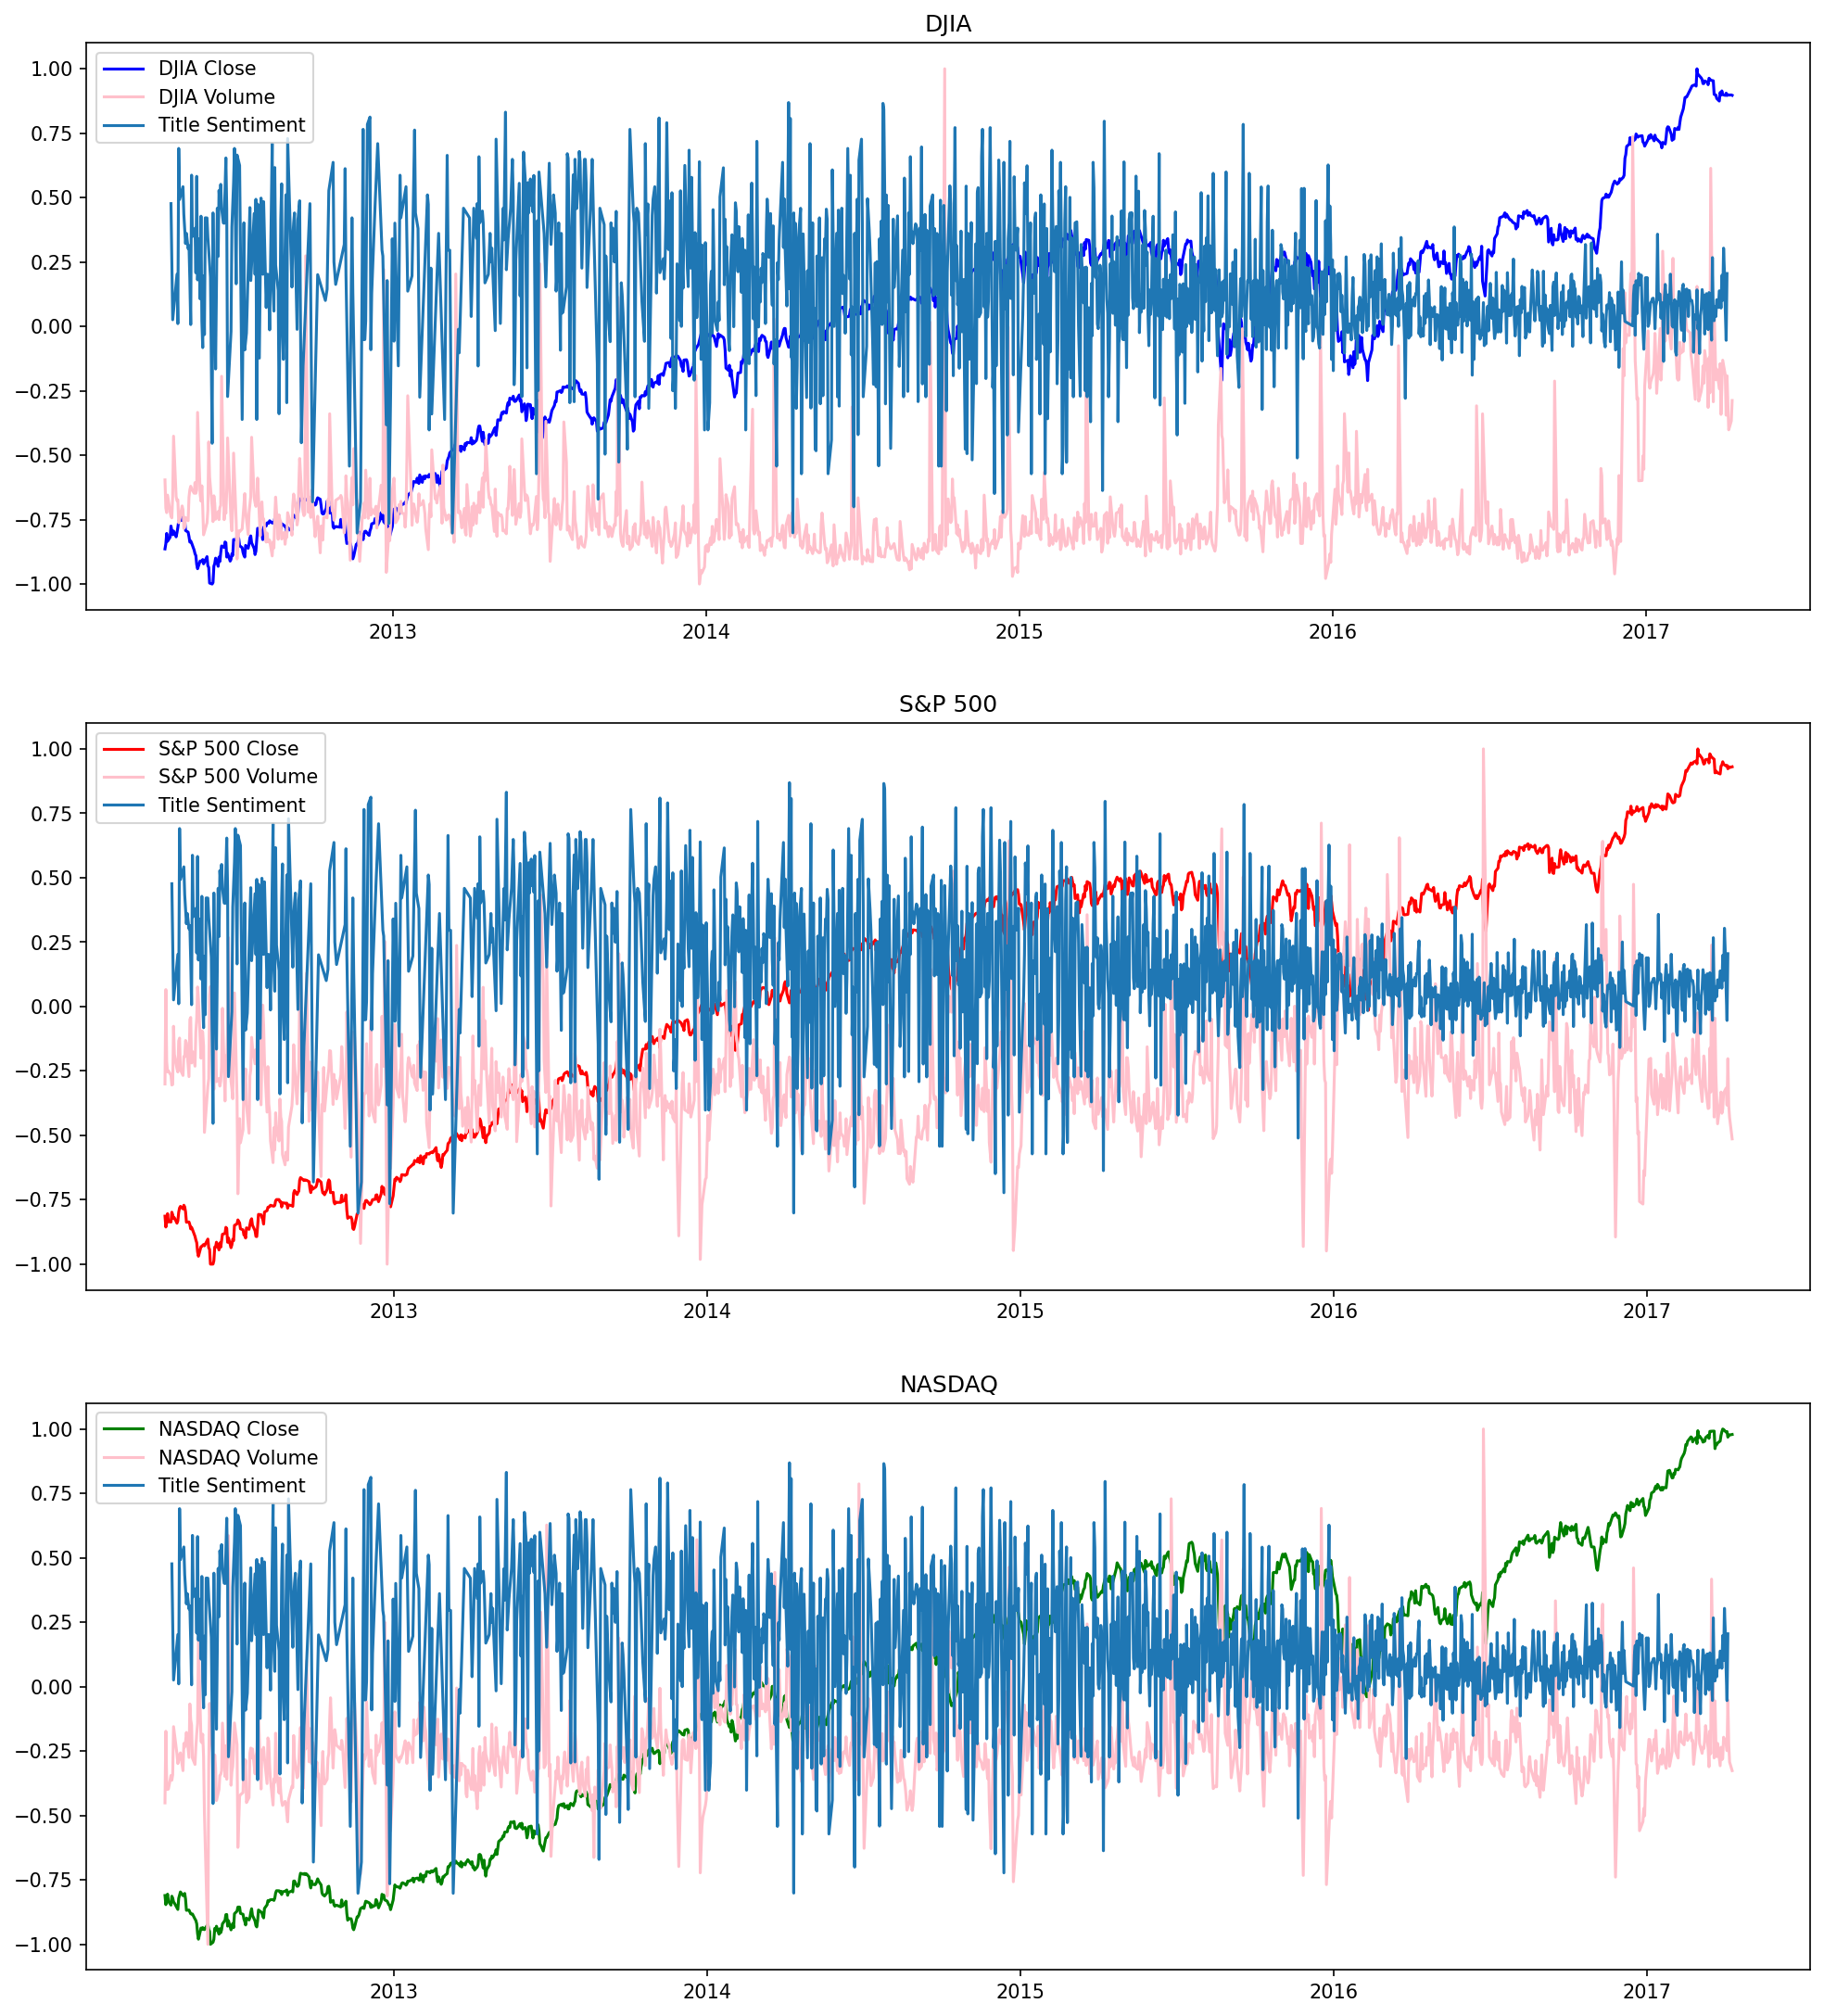

In [100]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Title Sentiment (Daily Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(titleSentiment['date'], titleSentiment['TitleDailySentimentAverage'], label='Title Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(titleSentiment['date'], titleSentiment['TitleDailySentimentAverage'], label='Title Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(titleSentiment['date'], titleSentiment['TitleDailySentimentAverage'], label='Title Sentiment')
axes[2].legend()

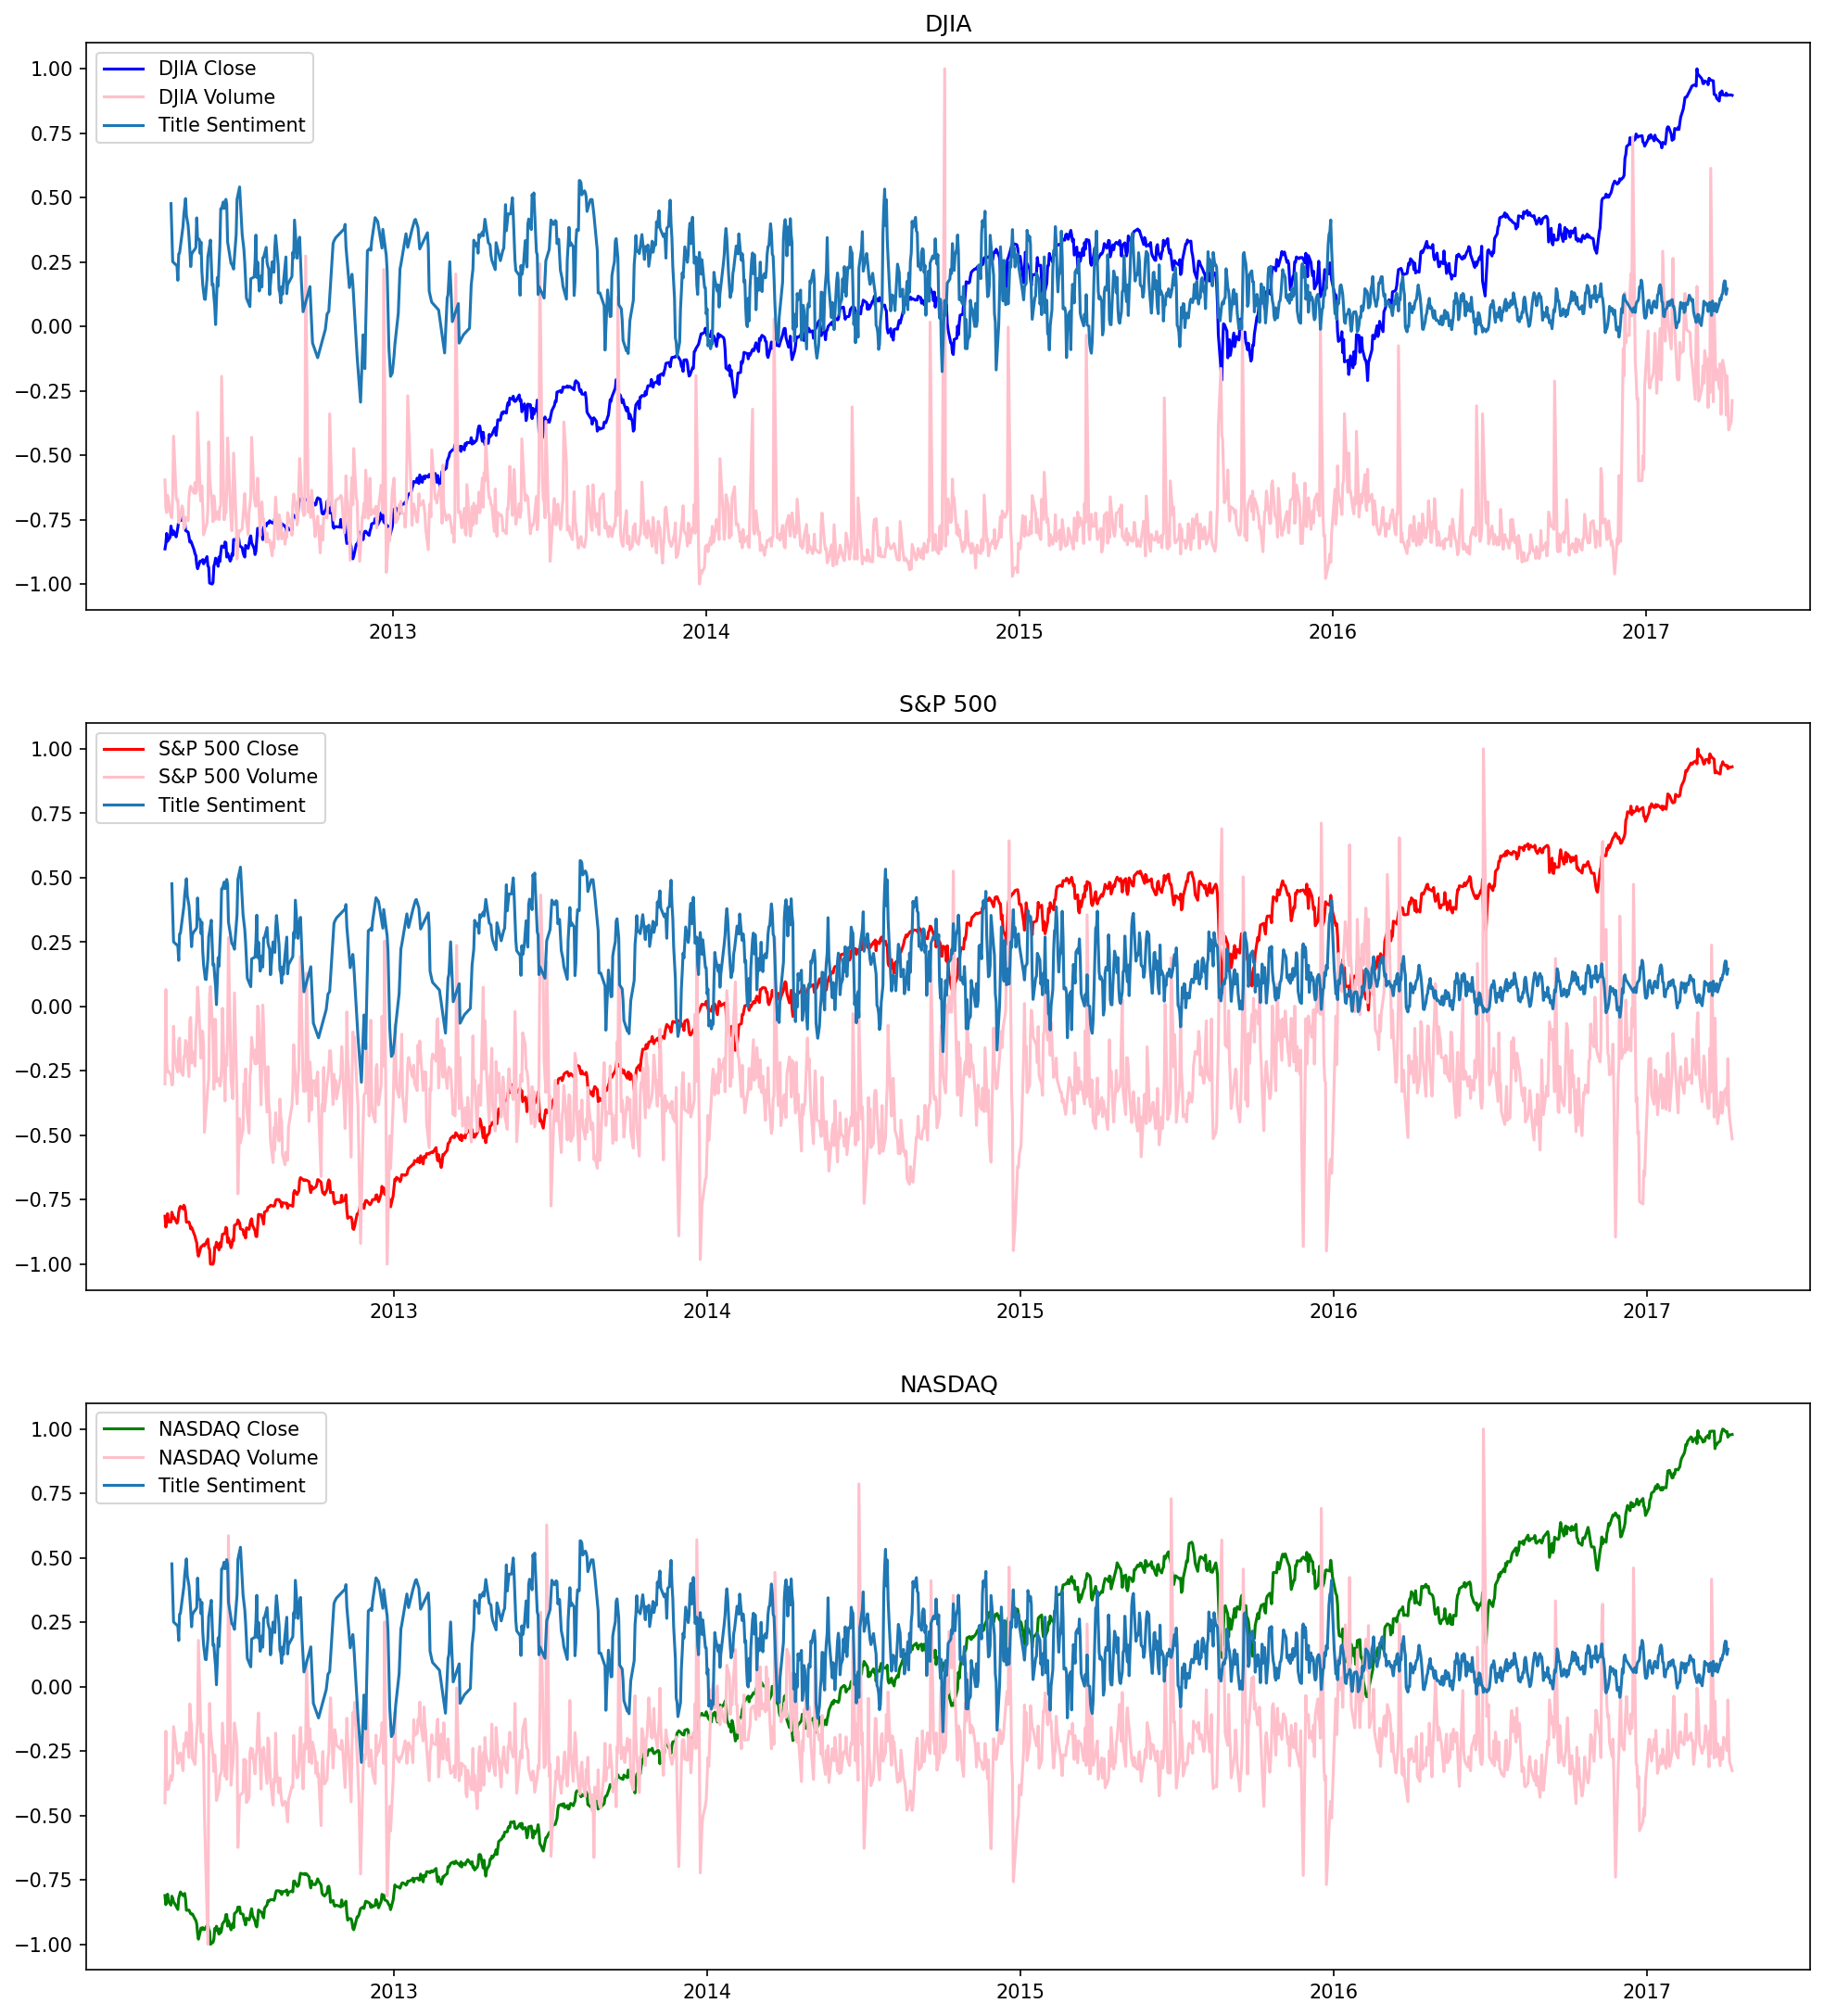

In [101]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Title Sentiment (5 Day Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(titleSentiment['date'], titleSentiment['TitleSentimentFiveDayAverage'], label='Title Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(titleSentiment['date'], titleSentiment['TitleSentimentFiveDayAverage'], label='Title Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(titleSentiment['date'], titleSentiment['TitleSentimentFiveDayAverage'], label='Title Sentiment')
axes[2].legend()

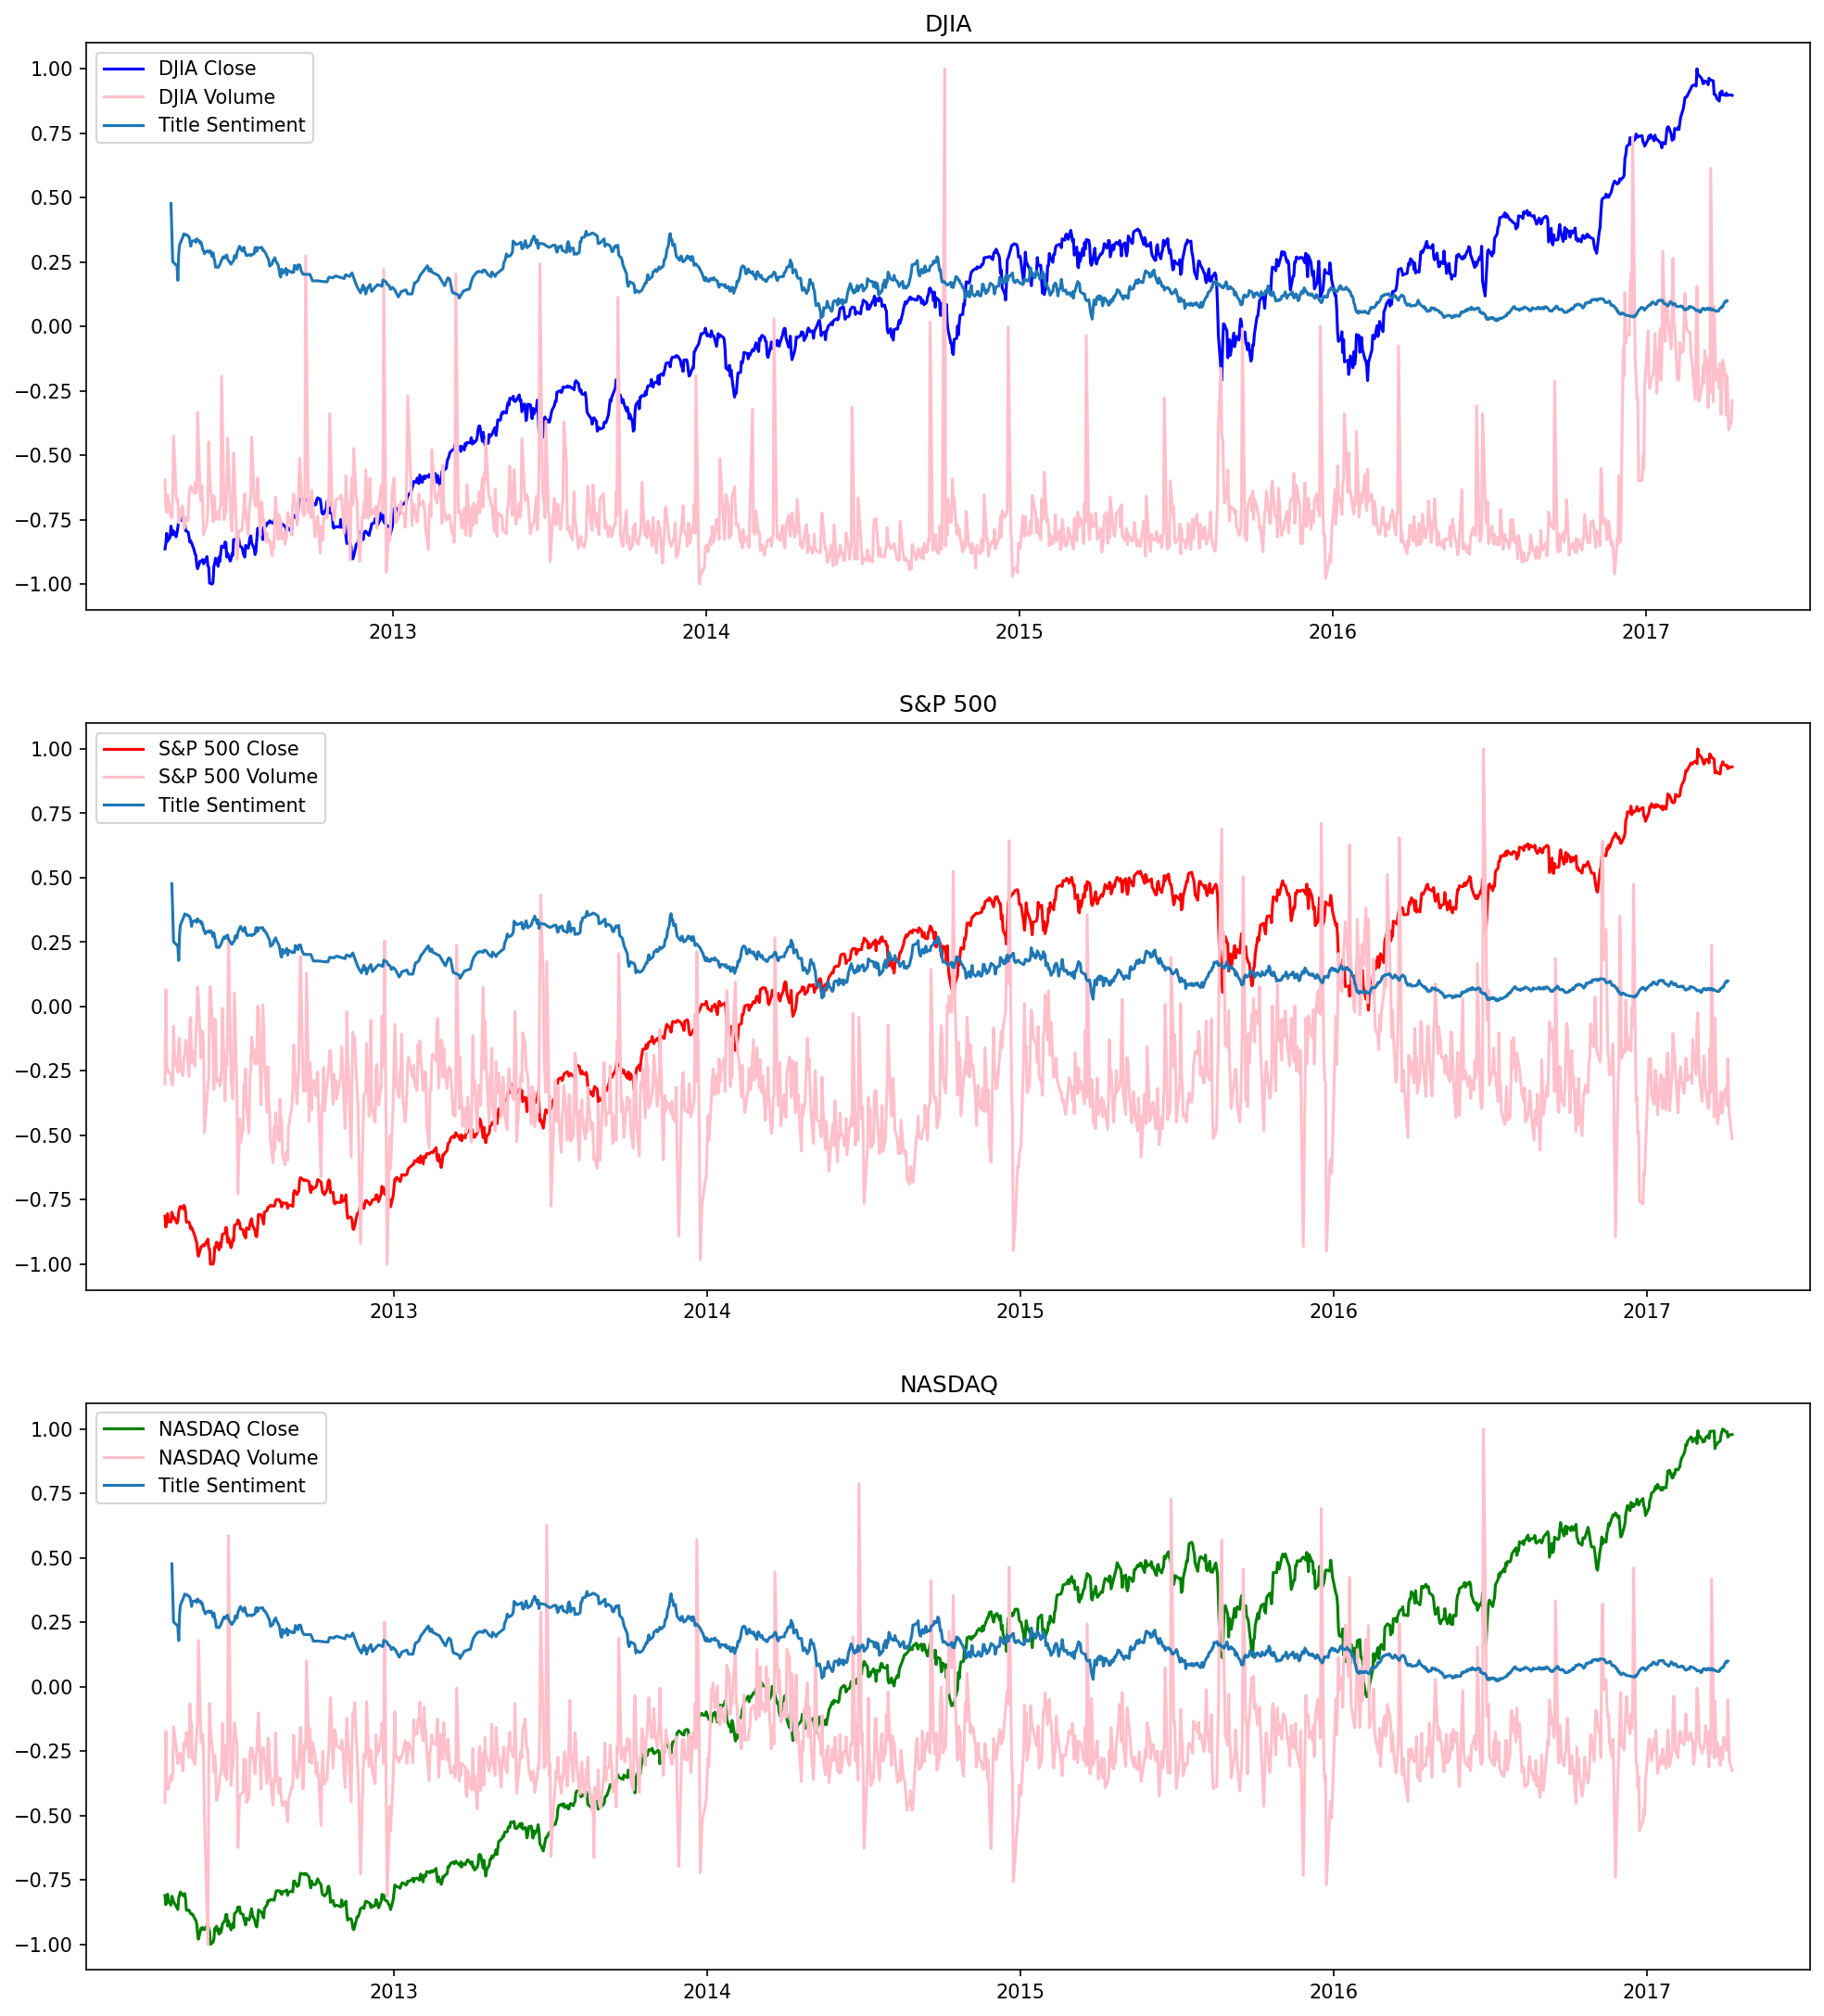

In [102]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Title Sentiment (30 Day Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(titleSentiment['date'], titleSentiment['TitleSentiment30DayAverage'], label='Title Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(titleSentiment['date'], titleSentiment['TitleSentiment30DayAverage'], label='Title Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(titleSentiment['date'], titleSentiment['TitleSentiment30DayAverage'], label='Title Sentiment')
axes[2].legend()

## Body Sentiment vs Exchanges

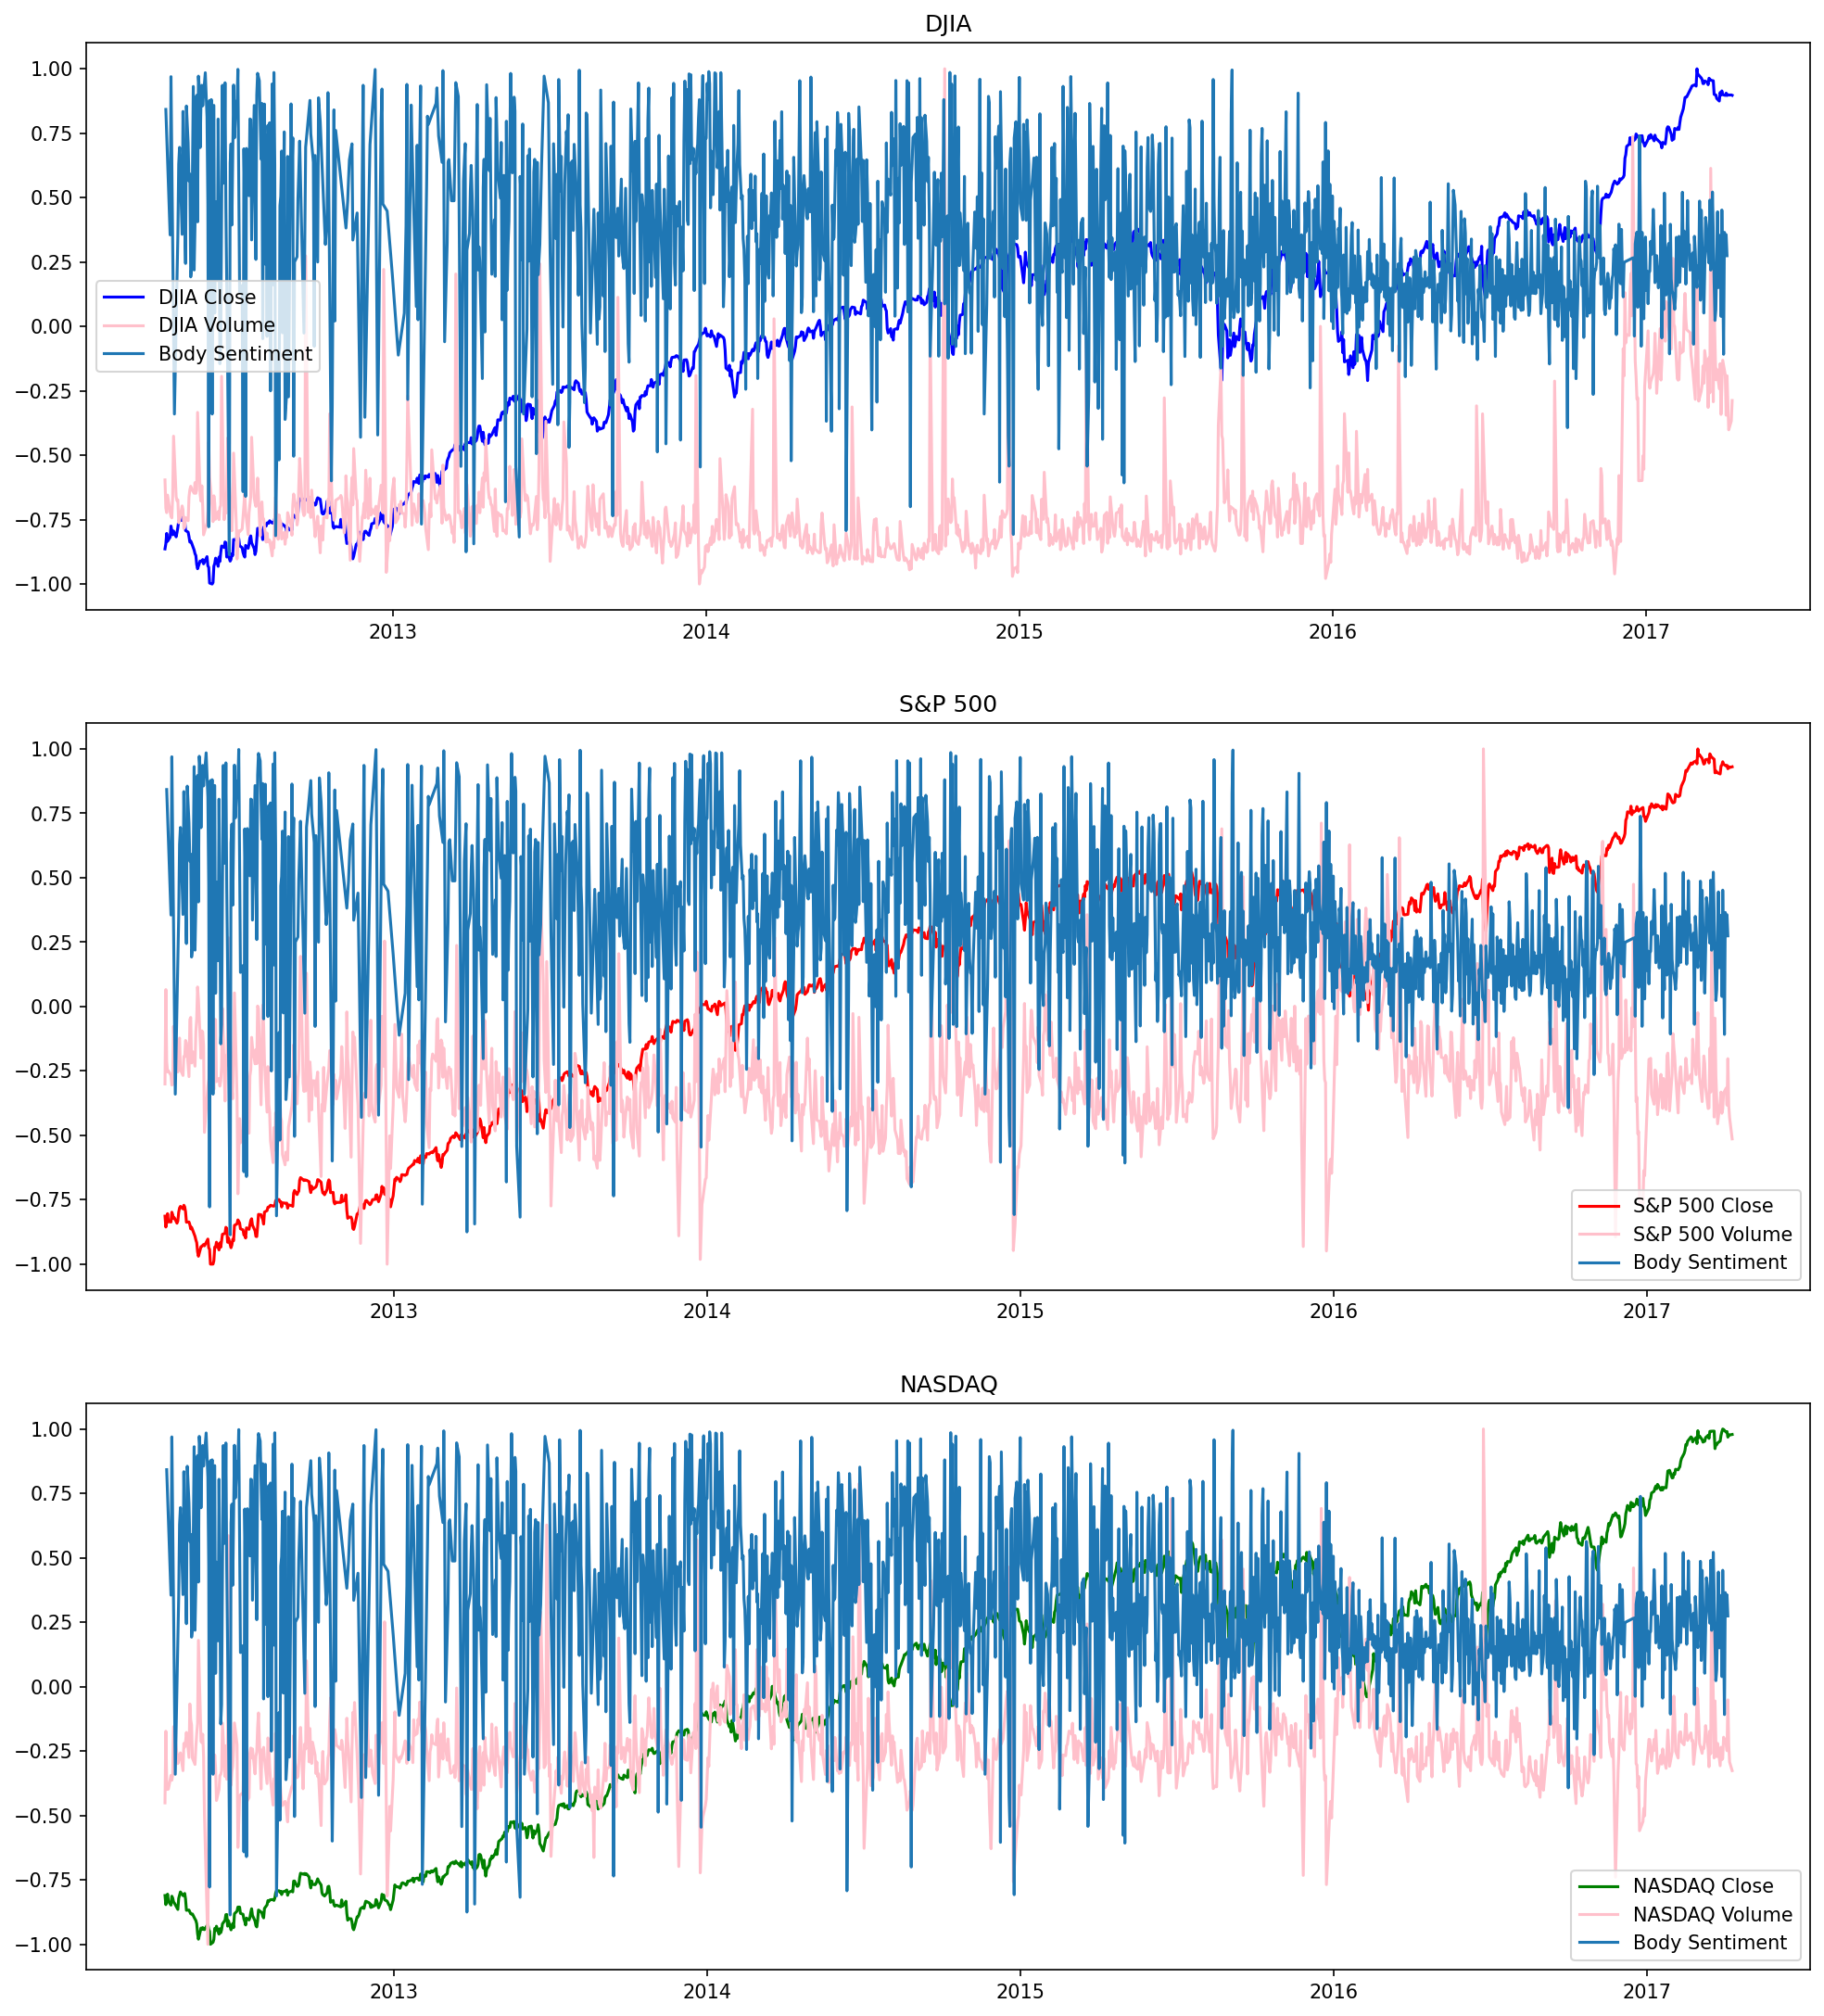

In [103]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Body Sentiment (Daily Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(bodySentiment['date'], bodySentiment['BodyDailySentimentAverage'], label='Body Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(bodySentiment['date'], bodySentiment['BodyDailySentimentAverage'], label='Body Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(bodySentiment['date'], bodySentiment['BodyDailySentimentAverage'], label='Body Sentiment')
axes[2].legend()

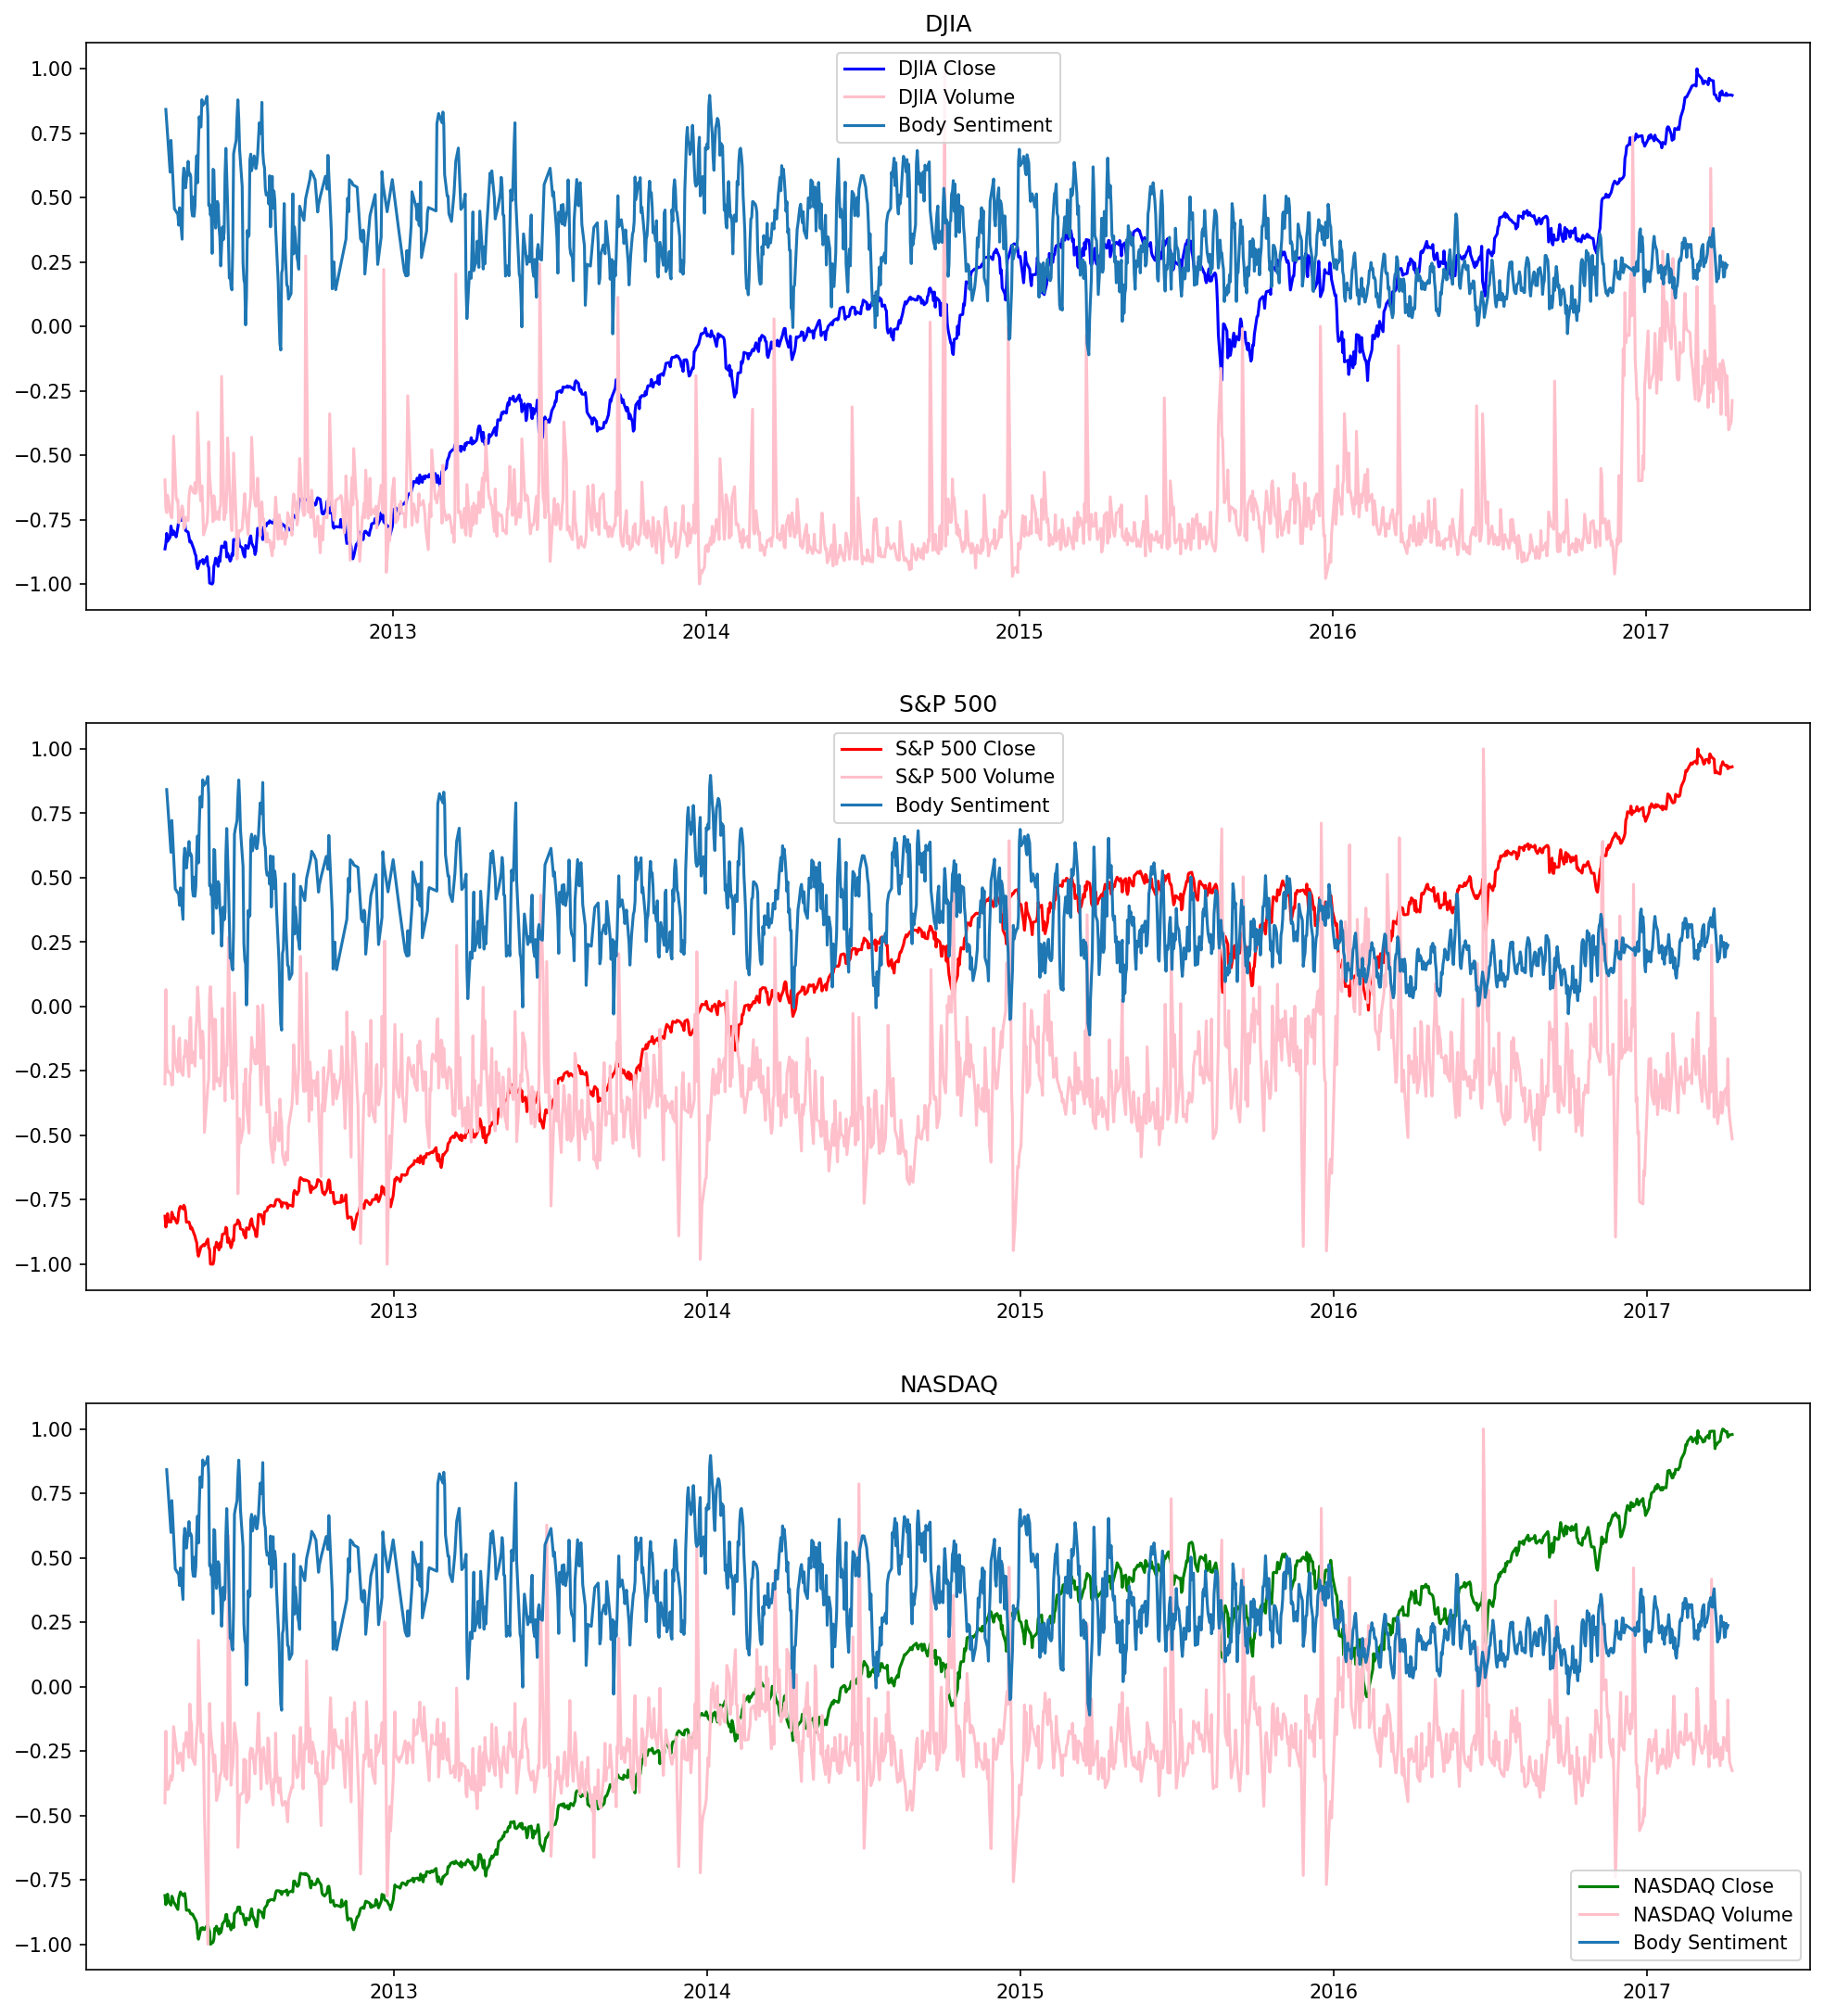

In [104]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Body Sentiment (5 Day Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(bodySentiment['date'], bodySentiment['BodySentimentFiveDayAverage'], label='Body Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(bodySentiment['date'], bodySentiment['BodySentimentFiveDayAverage'], label='Body Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(bodySentiment['date'], bodySentiment['BodySentimentFiveDayAverage'], label='Body Sentiment')
axes[2].legend()

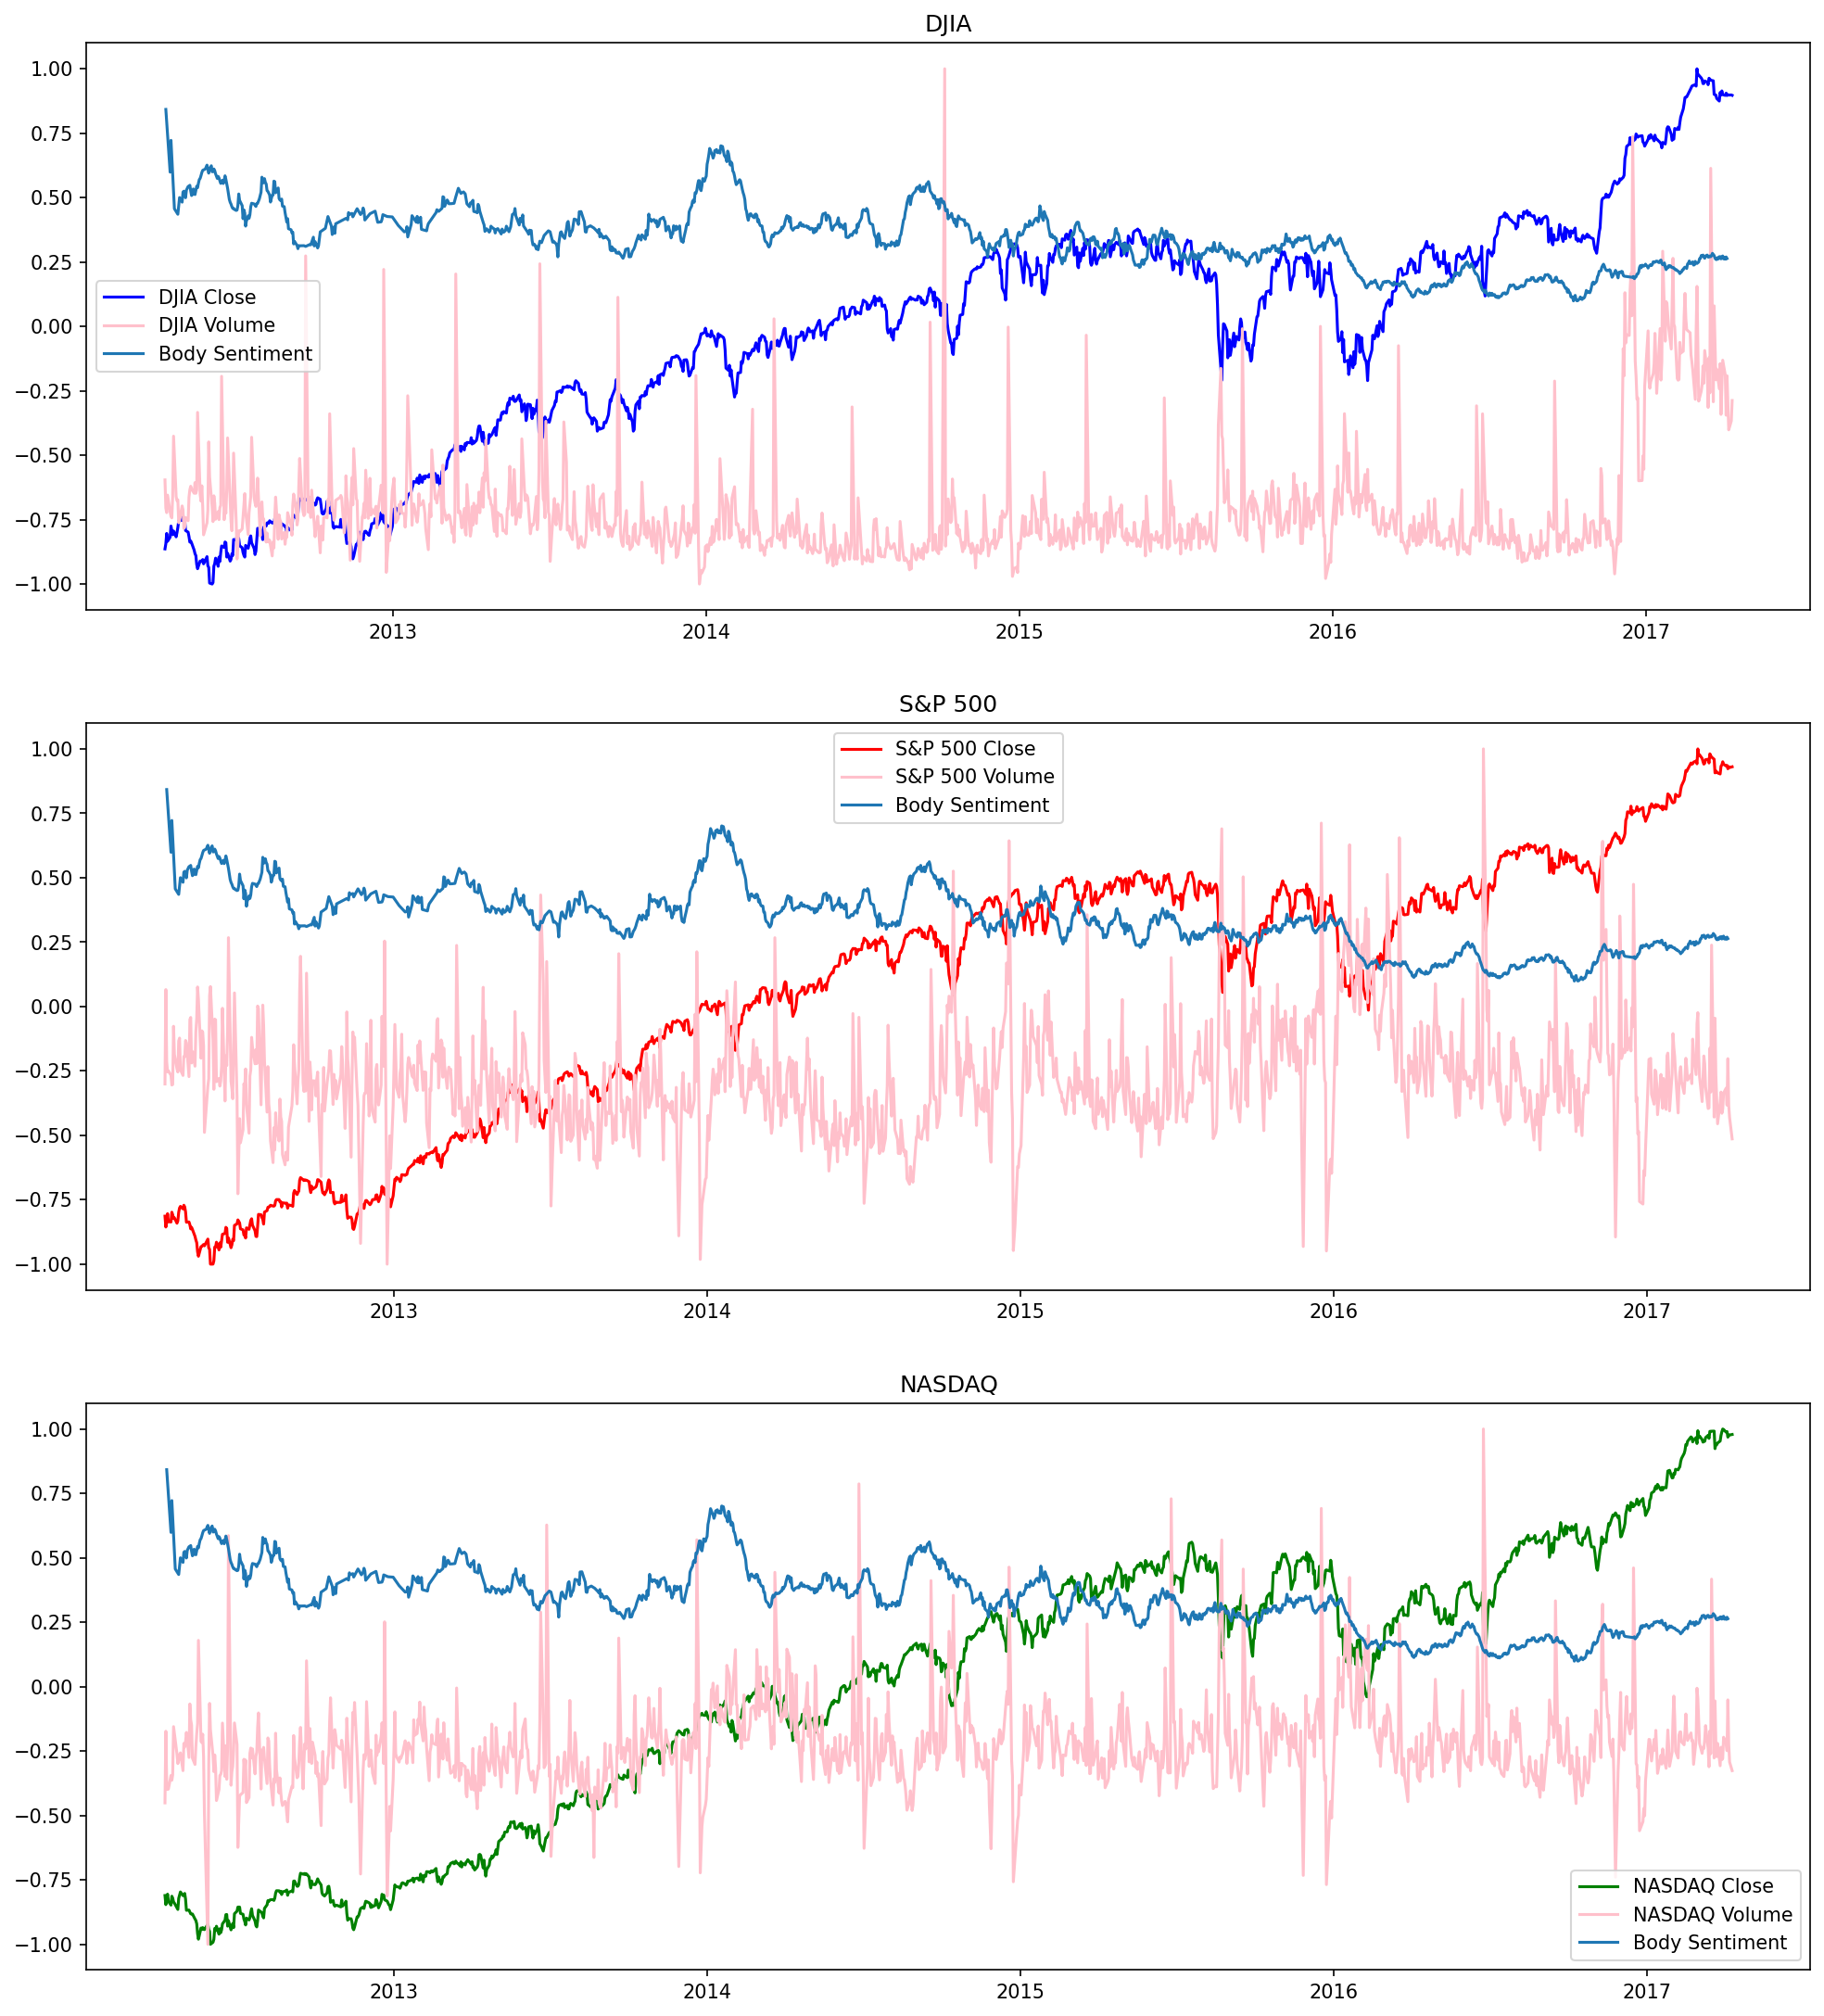

In [105]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Body Sentiment (30 Day Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(bodySentiment['date'], bodySentiment['BodySentiment30DayAverage'], label='Body Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(bodySentiment['date'], bodySentiment['BodySentiment30DayAverage'], label='Body Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(bodySentiment['date'], bodySentiment['BodySentiment30DayAverage'], label='Body Sentiment')
axes[2].legend()

## Comment Sentiment vs Exchanges

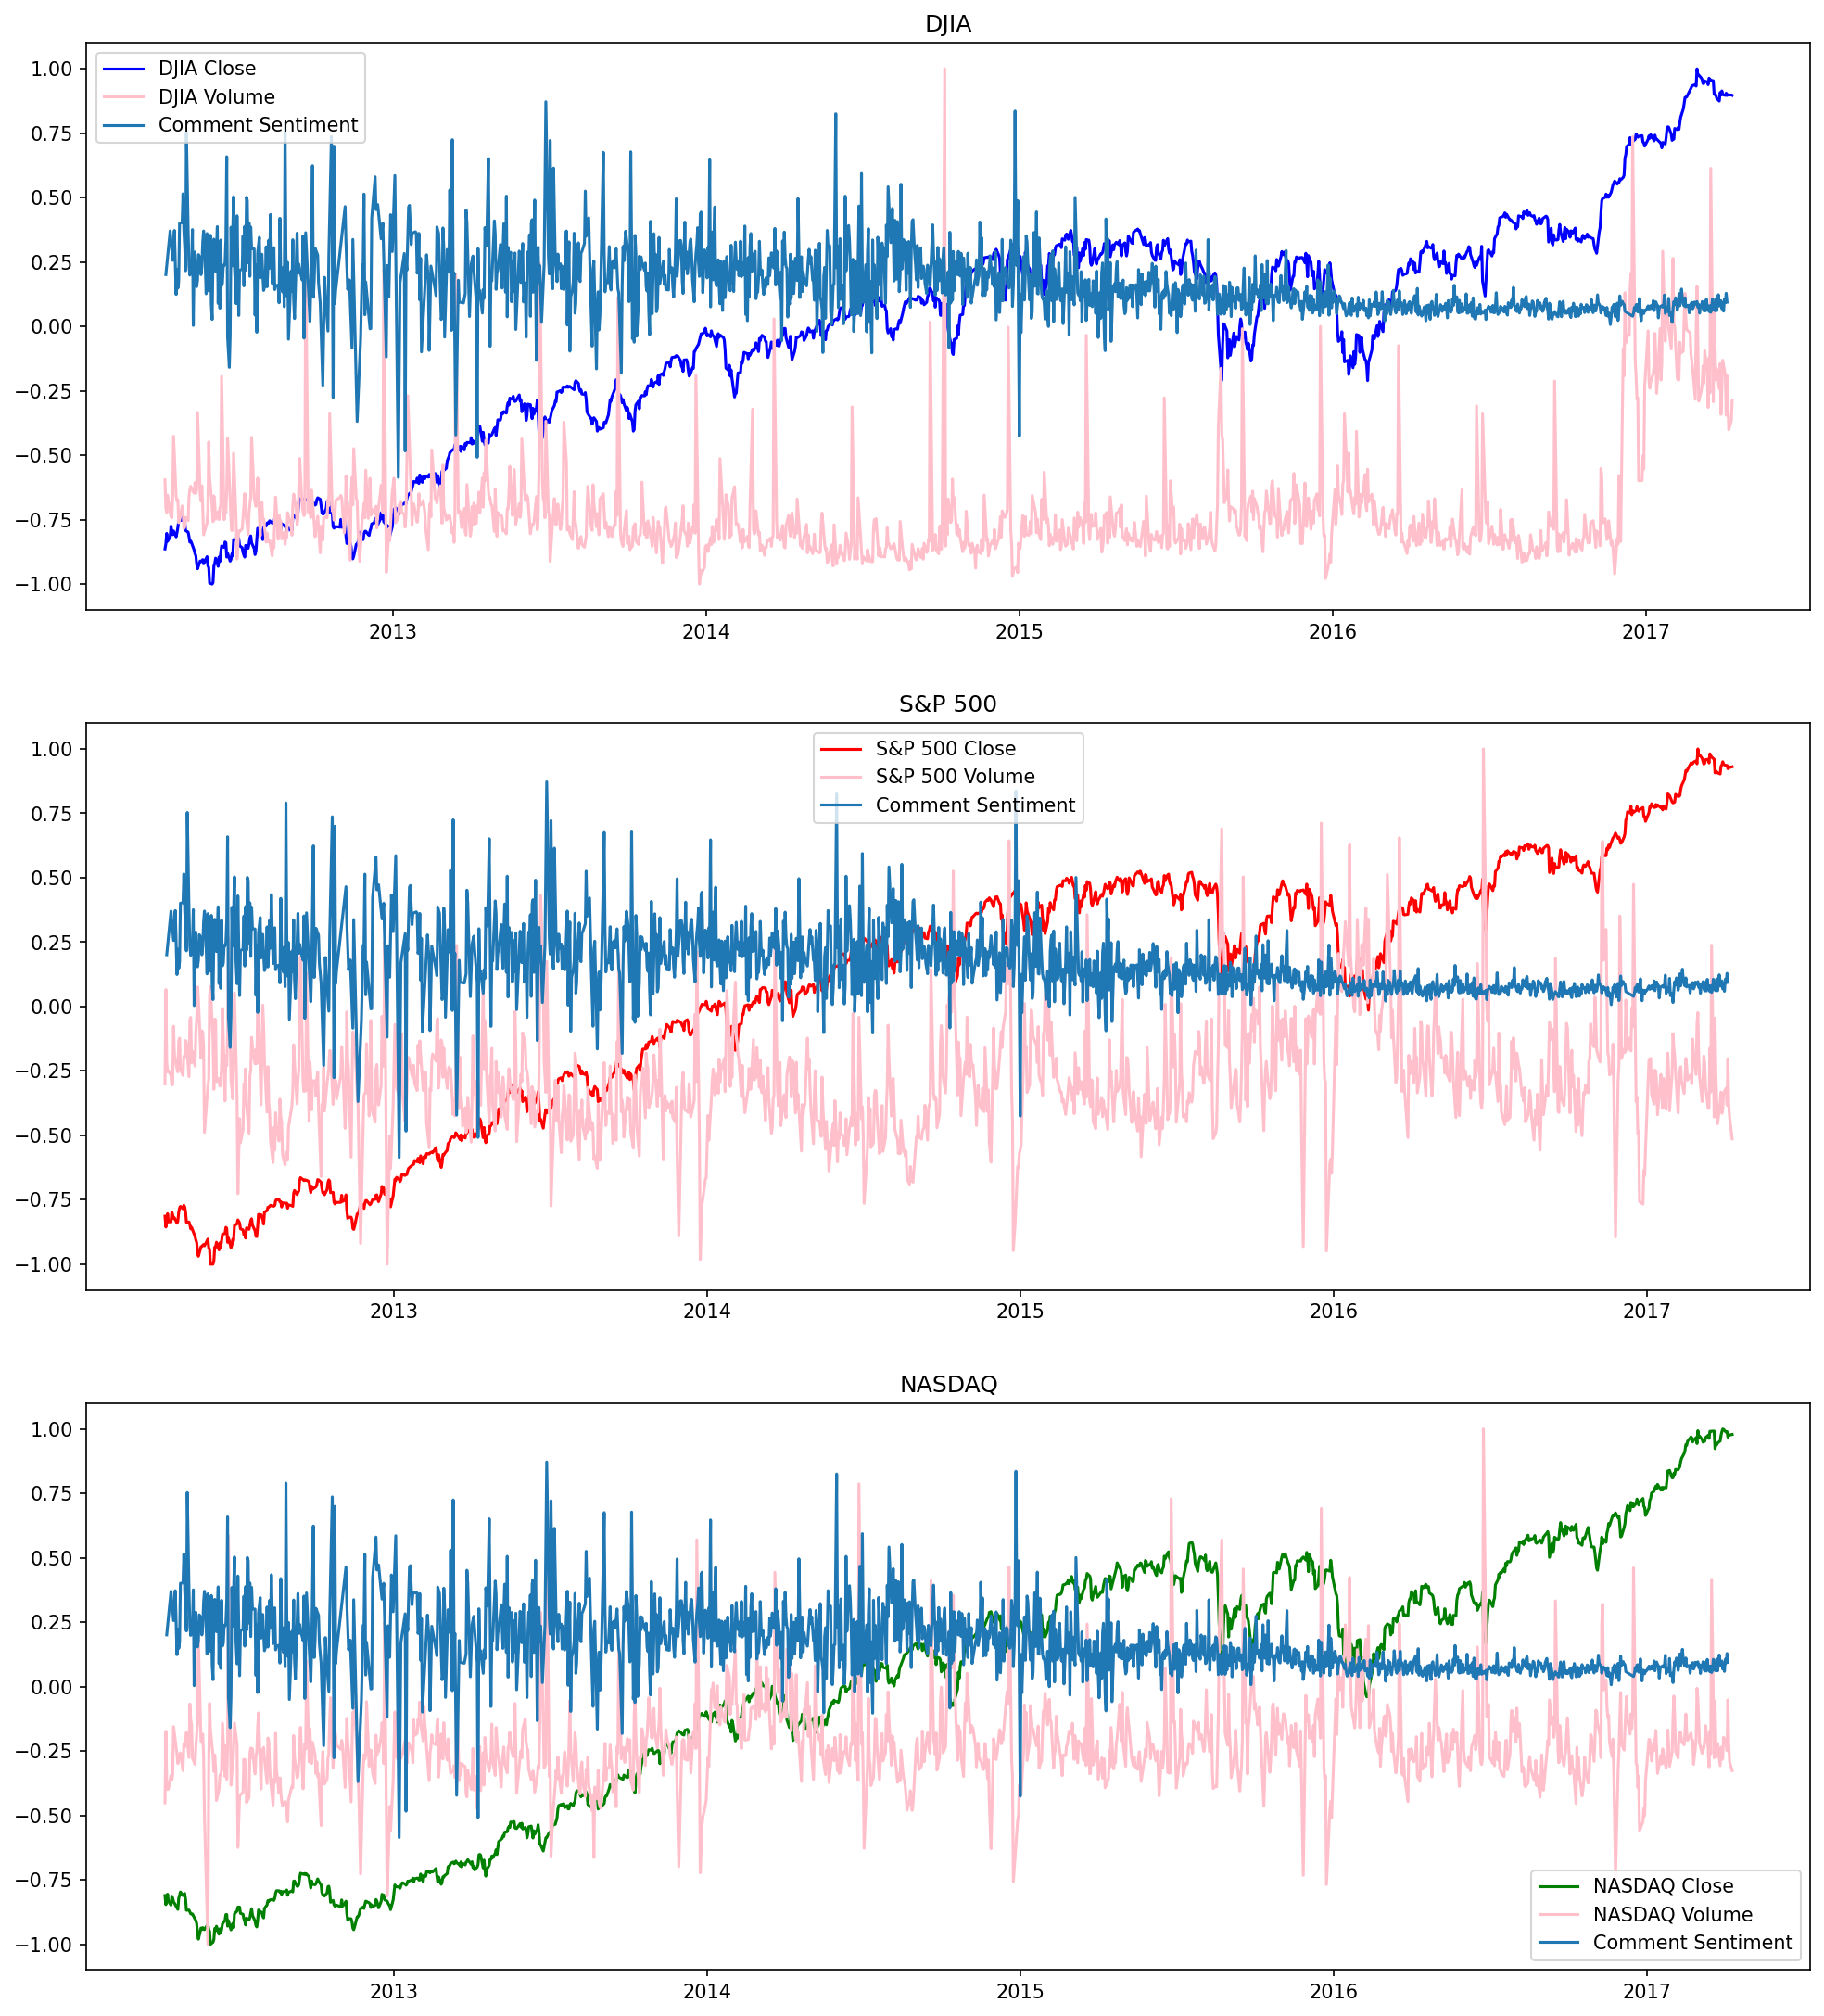

In [108]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Comment Sentiment (Daily Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(commentSentiment['date'], commentSentiment['CommentDailySentimentAverage'], label='Comment Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(commentSentiment['date'], commentSentiment['CommentDailySentimentAverage'], label='Comment Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(commentSentiment['date'], commentSentiment['CommentDailySentimentAverage'], label='Comment Sentiment')
axes[2].legend()

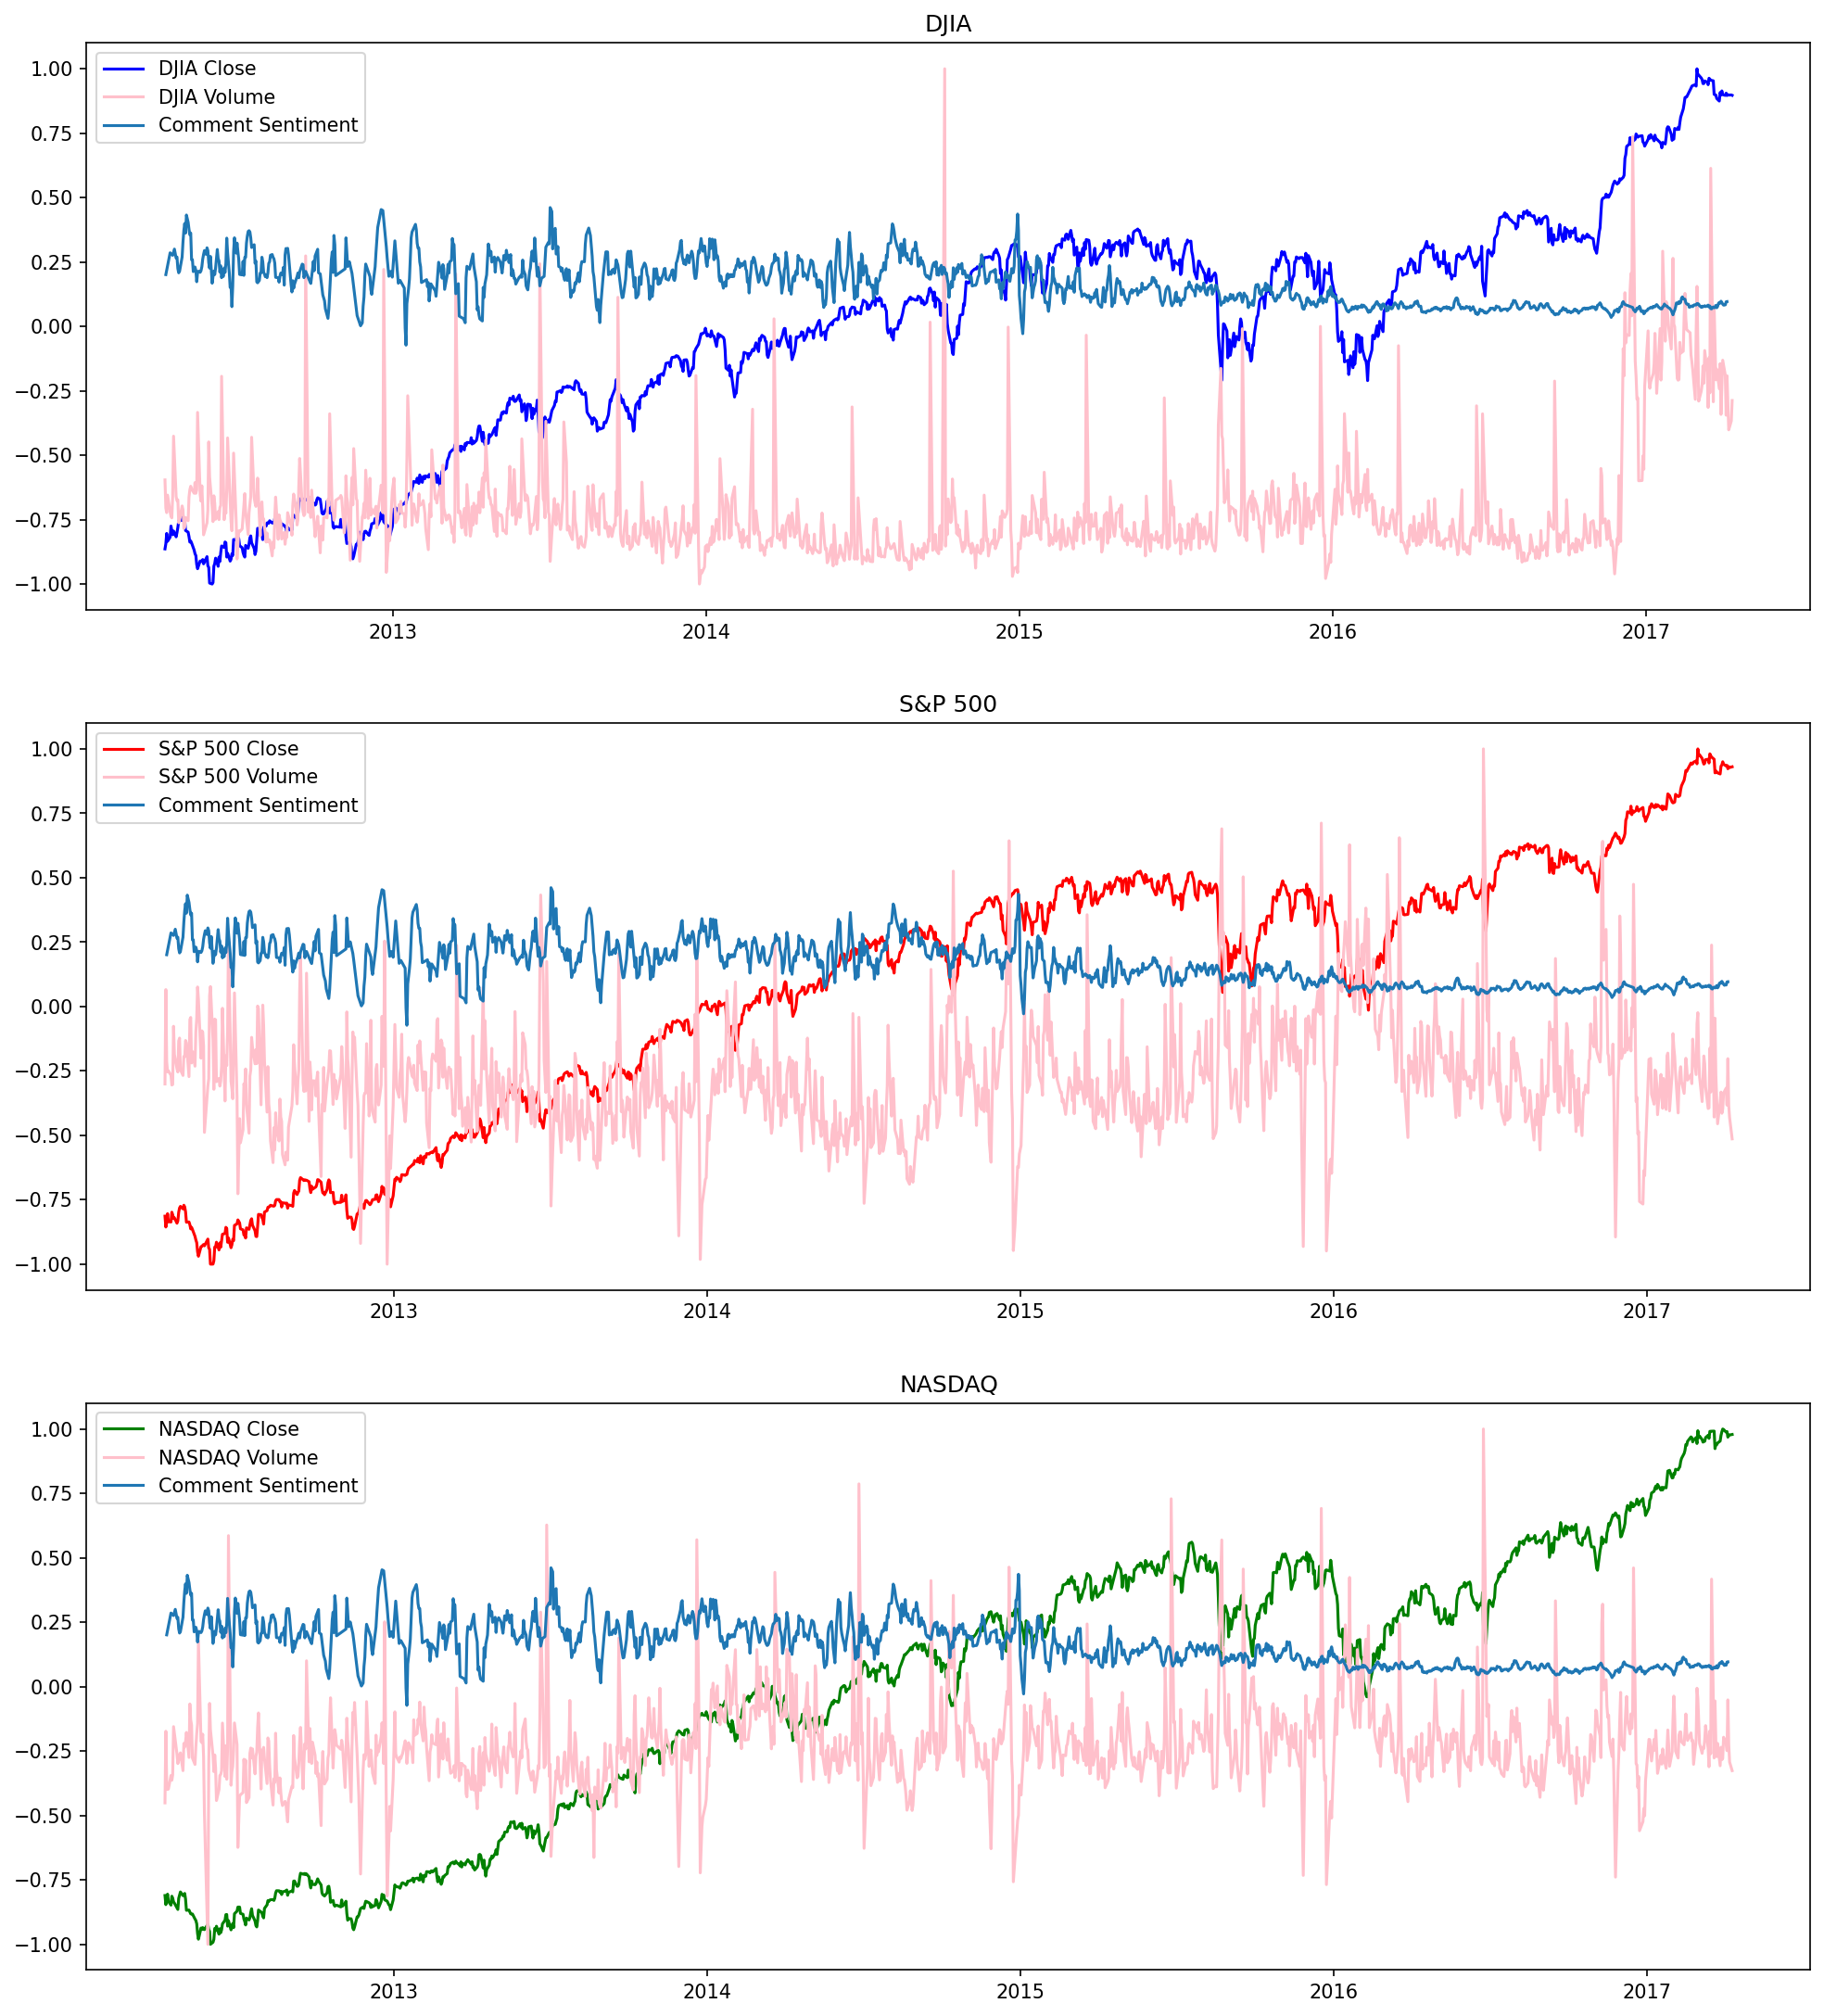

In [106]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Comment Sentiment (5 Day Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(commentSentiment['date'], commentSentiment['CommentSentimentFiveDayAverage'], label='Comment Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(commentSentiment['date'], commentSentiment['CommentSentimentFiveDayAverage'], label='Comment Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(commentSentiment['date'], commentSentiment['CommentSentimentFiveDayAverage'], label='Comment Sentiment')
axes[2].legend()

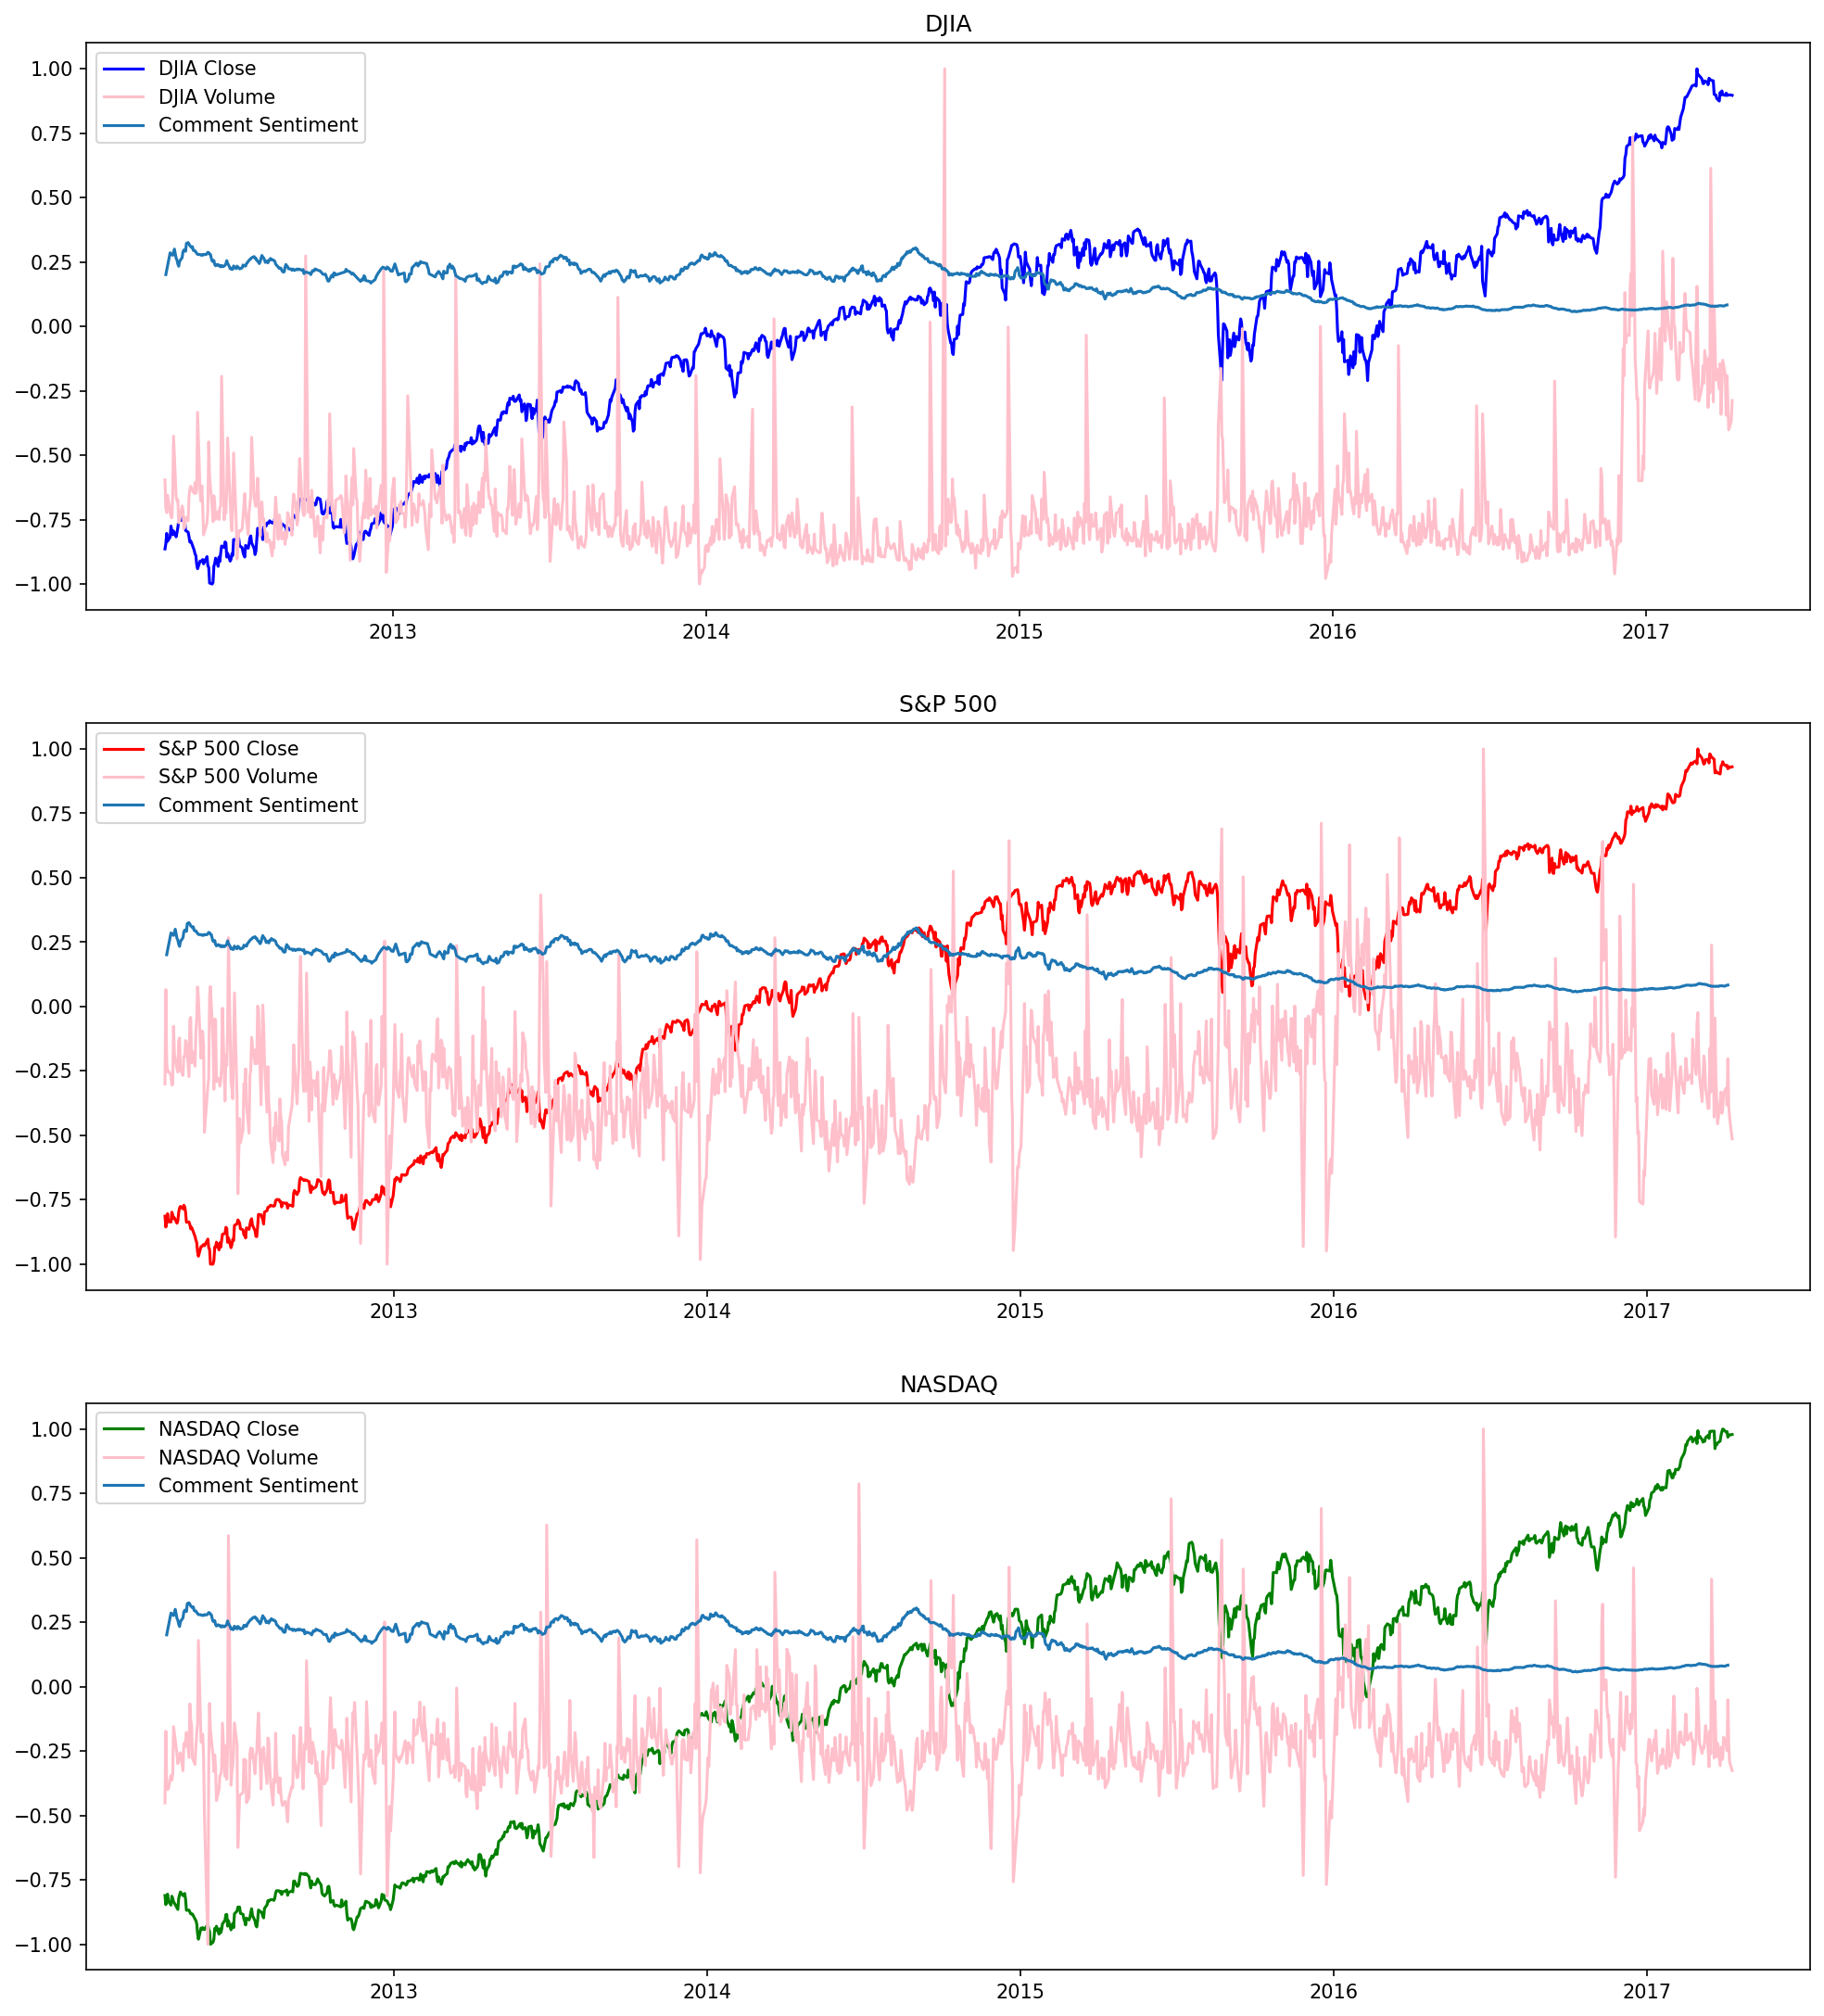

In [107]:
fig, axes = plt.subplots(3, figsize=(16, 18), dpi=150)
plt.title('Indexes vs Comment Sentiment (30 Day Average)')

axes[0].set_title('DJIA')
axes[0].plot(djia['date'], djia['NormalizedClose'], label='DJIA Close', color='blue')
axes[0].plot(djia['date'], djia['NormalizedVolume'], label='DJIA Volume', color='pink')
axes[0].plot(commentSentiment['date'], commentSentiment['CommentSentiment30DayAverage'], label='Comment Sentiment')
axes[0].legend()

axes[1].set_title('S&P 500')
axes[1].plot(sp500['date'], sp500['NormalizedClose'], label='S&P 500 Close', color='red')
axes[1].plot(sp500['date'], sp500['NormalizedVolume'], label='S&P 500 Volume', color='pink')
axes[1].plot(commentSentiment['date'], commentSentiment['CommentSentiment30DayAverage'], label='Comment Sentiment')
axes[1].legend()

axes[2].set_title('NASDAQ')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedClose'], label='NASDAQ Close', color='green')
axes[2].plot(nasdaq['date'], nasdaq['NormalizedVolume'], label='NASDAQ Volume', color='pink')
axes[2].plot(commentSentiment['date'], commentSentiment['CommentSentiment30DayAverage'], label='Comment Sentiment')
axes[2].legend()